# Import Libraries

In [24]:
import os, sys, json, cv2, time, glob, gc, datetime
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import matplotlib.patches as patches

from tqdm import tqdm
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, Reshape
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler, TensorBoard, ModelCheckpoint
from tensorflow.keras.regularizers import l1, l2, l1_l2
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from kerastuner import HyperModel, Hyperband
from kerastuner.tuners import RandomSearch
from keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

# Configurations

In [25]:
# Setup the paths to train and test images
TRAIN_DIR = './global-wheat-detection/train/'
TEST_DIR = './global-wheat-detection/test/'
TRAIN_CSV_PATH = './global-wheat-detection/train.csv'
AUG_SAVE_DIR = './global-wheat-detection/augmented_images/'
SAVE_PATH = 'models/CustomCNN/'
CHECKPOINT_DIR = 'models/CustomCNN/checkpoints/'

EPOCHS = 20
IMG_SIZE = 256
BATCH_SIZE = 32

# Create a directory if it doesn't exist
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)
if not os.path.exists(CHECKPOINT_DIR):
    os.makedirs(CHECKPOINT_DIR)

# Data Loading

In [26]:
df = pd.read_csv('./df_augment.csv')
# df = pd.read_csv('./df_full.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242466 entries, 0 to 242465
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   image_id  242466 non-null  object 
 1   x         242466 non-null  float64
 2   y         242466 non-null  float64
 3   w         242466 non-null  float64
 4   h         242466 non-null  float64
 5   source    242466 non-null  object 
dtypes: float64(4), object(2)
memory usage: 11.1+ MB


In [27]:
# Function to group bounding boxes
def group_bounding_boxes(group):
    bboxes = np.array(list(zip(group['x'], group['y'], group['w'], group['h'])), dtype=np.float32)
    return pd.Series([bboxes], index=['bboxes'])

# Group by image ID and apply the group_bounding_boxes function
df = df.groupby('image_id').apply(group_bounding_boxes).reset_index()

# Save the grouped DataFrame to a new CSV file
# grouped_df.to_csv('./df_grouped.csv', index=False)

In [28]:
max_bboxes = max(df['bboxes'].apply(len))
print(f"Maximum number of bounding boxes in the dataset: {max_bboxes}")

def load_image_and_bbox(image_id, bboxes, max_bboxes=max_bboxes):
    image = tf.io.read_file(image_id)
    image = tf.image.decode_jpeg(image, channels=3)
    original_size = tf.shape(image)[:2]
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    
    image = image / 255.0
    
    # Adjust bounding boxes
    scale = tf.cast(original_size[0], tf.float32) / IMG_SIZE
    bboxes = bboxes / scale
    # bboxes = tf.pad(bboxes, [[0, max_bboxes - tf.shape(bboxes)[0]], [0, 0]])
    return image, bboxes

def parse_dataframe(df, TRAIN_DIR=TRAIN_DIR, AUG_SAVE_DIR=AUG_SAVE_DIR):
    image_ids = []
    all_bboxes = []
    for i, row in tqdm(df.iterrows(), total=len(df), desc='Parsing dataframe and image path'):
        image_id = row['image_id']
        ori_image_path = f'{TRAIN_DIR}/{image_id}.jpg'
        augmented_image_path = f'{AUG_SAVE_DIR}/{image_id}.jpg'
        if os.path.exists(ori_image_path):
            image_path = ori_image_path
        else:
            image_path = augmented_image_path
        image_ids.append(image_path)
        bboxes = row['bboxes']
        bboxes = tf.pad(bboxes, [[0, max_bboxes - tf.shape(bboxes)[0]], [0, 0]])
        all_bboxes.append(bboxes)
    return image_ids, all_bboxes

def create_dataset(image_paths, bboxes, batch_size=BATCH_SIZE):
    # def generator():
    #     for img_path, bbox in zip(image_paths, bboxes):
    #         yield img_path, bbox
    
    # dataset = tf.data.Dataset.from_generator(
    #     generator,
    #     output_signature=(
    #         tf.TensorSpec(shape=(), dtype=tf.string),
    #         tf.TensorSpec(shape=(None, 4), dtype=tf.float32)
    #     )
    # )
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, bboxes))
    dataset = dataset.map(lambda x, y: load_image_and_bbox(x, y), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

image_ids, bboxes = parse_dataframe(df)


Maximum number of bounding boxes in the dataset: 116


Parsing dataframe and image path: 100%|██████████| 6767/6767 [00:12<00:00, 559.51it/s]


In [29]:
# Split the dataset
train_paths, test_paths, train_bboxes, test_bboxes = train_test_split(image_ids, bboxes, test_size=0.4, random_state=42)
test_paths, val_paths, test_bboxes, val_bboxes = train_test_split(test_paths, test_bboxes, test_size=0.5, random_state=42)

# Create TensorFlow Datasets
train_dataset = create_dataset(train_paths, train_bboxes)
val_dataset = create_dataset(val_paths, val_bboxes)
test_dataset = create_dataset(test_paths, test_bboxes)

train_dataset = train_dataset.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.float32)))
val_dataset = val_dataset.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.float32)))
test_dataset = test_dataset.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.float32)))

In [30]:
for images, bboxes in train_dataset.take(1):
    print(images.shape, bboxes.shape, len(train_dataset))
for images, bboxes in test_dataset.take(1):
    print(images.shape, bboxes.shape, len(test_dataset))
for images, bboxes in val_dataset.take(1):
    print(images.shape, bboxes.shape, len(val_dataset))

(32, 256, 256, 3) (32, 116, 4) 127
(32, 256, 256, 3) (32, 116, 4) 43
(32, 256, 256, 3) (32, 116, 4) 43


# Model building

In [31]:
def plot_metrics(history):
    # Extract metrics from the history object
    metrics = {
        'loss': history.history.get('loss', []),
        'val_loss': history.history.get('val_loss', []),
        'iou': history.history.get('iou', []),
        'val_iou': history.history.get('val_iou', []),
        'precision': history.history.get('precision', []),
        'val_precision': history.history.get('val_precision', []),
        'recall': history.history.get('recall', []),
        'val_recall': history.history.get('val_recall', []),
        'f1_score': history.history.get('f1_score', []),
        'val_f1_score': history.history.get('val_f1_score', []),
        'mean_average_precision': history.history.get('mean_average_precision', []),
        'val_mean_average_precision': history.history.get('val_mean_average_precision', []),
        'auc': history.history.get('auc', []),
        'val_auc': history.history.get('val_auc', []),
        'lr': history.history.get('lr', [])
    }
    epochs = range(1, len(metrics['loss']) + 1)

    # Plot loss
    plt.figure(figsize=(18, 12))
    plt.subplot(3, 3, 1)
    plt.plot(metrics['loss'])
    if metrics['val_loss']:
        plt.plot(metrics['val_loss'])
        plt.legend(['Train', 'Validation'], loc='upper left')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.xticks(epochs)

    # Plot IoU
    plt.subplot(3, 3, 2)
    plt.plot(metrics['iou'])
    if metrics['val_iou']:
        plt.plot(metrics['val_iou'])
        plt.legend(['Train', 'Validation'], loc='upper left')
    plt.title('Model IoU')
    plt.ylabel('IoU')
    plt.xlabel('Epoch')
    plt.xticks(epochs)

    # Plot precision
    plt.subplot(3, 3, 3)
    plt.plot(metrics['precision'])
    if metrics['val_precision']:
        plt.plot(metrics['val_precision'])
        plt.legend(['Train', 'Validation'], loc='upper left')
    plt.title('Model Precision')
    plt.ylabel('Precision')
    plt.xlabel('Epoch')
    plt.xticks(epochs)

    # Plot recall
    plt.subplot(3, 3, 4)
    plt.plot(metrics['recall'])
    if metrics['val_recall']:
        plt.plot(metrics['val_recall'])
        plt.legend(['Train', 'Validation'], loc='upper left')
    plt.title('Model Recall')
    plt.ylabel('Recall')
    plt.xlabel('Epoch')
    plt.xticks(epochs)

    # Plot F1-score
    plt.subplot(3, 3, 5)
    plt.plot(metrics['f1_score'])
    if metrics['val_f1_score']:
        plt.plot(metrics['val_f1_score'])
        plt.legend(['Train', 'Validation'], loc='upper left')
    plt.title('Model F1-Score')
    plt.ylabel('F1-Score')
    plt.xlabel('Epoch')
    plt.xticks(epochs)

    # Plot mean average precision
    plt.subplot(3, 3, 6)
    plt.plot(metrics['mean_average_precision'])
    if metrics['val_mean_average_precision']:
        plt.plot(metrics['val_mean_average_precision'])
        plt.legend(['Train', 'Validation'], loc='upper left')
    plt.title('Model Mean Average Precision')
    plt.ylabel('Mean Average Precision')
    plt.xlabel('Epoch')
    plt.xticks(epochs)

    # Plot learning rate
    plt.subplot(3, 3, 8)
    plt.plot(metrics['lr'])
    plt.title('Learning Rate')
    plt.ylabel('Learning Rate')
    plt.xlabel('Epoch')
    plt.xticks(epochs)

    plt.tight_layout()
    plt.show()

In [55]:
@tf.keras.utils.register_keras_serializable()
class IoU(tf.keras.metrics.Metric):
    def __init__(self, name='IoU', **kwargs):
        super(IoU, self).__init__(name=name, **kwargs)
        self.IoU_scores = self.add_weight(name='IoU_scores', initializer='zeros', dtype=tf.float32)
        self.total_samples = self.add_weight(name='total_samples', initializer='zeros', dtype=tf.float32)
    
    @tf.function(reduce_retracing=True)
    def update_state(self, y_true, y_pred, sample_weight=None):
        # Expand dimensions to handle batch size
        y_true = tf.expand_dims(y_true, axis=-2)
        y_pred = tf.expand_dims(y_pred, axis=-2)
        
        # Calculate intersection
        intersect_mins = tf.maximum(y_true[..., :2], y_pred[..., :2])
        intersect_maxs = tf.minimum(y_true[..., :2] + y_true[..., 2:], y_pred[..., :2] + y_pred[..., 2:])
        intersect_wh = tf.maximum(intersect_maxs - intersect_mins, 0.0)
        intersect_area = intersect_wh[..., 0] * intersect_wh[..., 1]
        
        # Calculate union
        true_area = y_true[..., 2] * y_true[..., 3]
        pred_area = y_pred[..., 2] * y_pred[..., 3]
        union_area = true_area + pred_area - intersect_area
        
        # Calculate IoU
        IoU_scores = intersect_area / (union_area + tf.keras.backend.epsilon())
        
        # Update the state variables
        self.IoU_scores.assign_add(tf.reduce_sum(IoU_scores))
        self.total_samples.assign_add(tf.cast(tf.shape(IoU_scores)[0], tf.float32))
    
    def result(self):
        return self.IoU_scores / (self.total_samples + tf.keras.backend.epsilon())
    
    def reset_states(self):
        self.IoU_scores.assign(0.0)
        self.total_samples.assign(0.0)
    
    def get_config(self):
        base_config = super(IoU, self).get_config()
        return {**base_config}

@tf.keras.utils.register_keras_serializable()
class PrecisionMetric(tf.keras.metrics.Metric):
    def __init__(self, IoU_threshold=0.5, name='precision', **kwargs):
        super(PrecisionMetric, self).__init__(name=name, **kwargs)
        self.IoU_threshold = IoU_threshold
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.false_positives = self.add_weight(name='fp', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        IoU_scores = IoU(y_true, y_pred)
        true_positives = tf.reduce_sum(tf.cast(IoU_scores >= self.IoU_threshold, tf.float32))
        false_positives = tf.reduce_sum(tf.cast(IoU_scores < self.IoU_threshold, tf.float32))
        self.true_positives.assign_add(true_positives)
        self.false_positives.assign_add(false_positives)

    def result(self):
        precision = self.true_positives / (self.true_positives + self.false_positives + tf.keras.backend.epsilon())
        return precision

    def reset_states(self):
        self.true_positives.assign(0)
        self.false_positives.assign(0)

@tf.keras.utils.register_keras_serializable()
class RecallMetric(tf.keras.metrics.Metric):
    def __init__(self, IoU_threshold=0.5, name='recall', **kwargs):
        super(RecallMetric, self).__init__(name=name, **kwargs)
        self.IoU_threshold = IoU_threshold
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        IoU_scores = IoU(y_true, y_pred)
        true_positives = tf.reduce_sum(tf.cast(IoU_scores >= self.IoU_threshold, tf.float32))
        false_negatives = tf.reduce_sum(tf.cast(IoU_scores < self.IoU_threshold, tf.float32))
        self.true_positives.assign_add(true_positives)
        self.false_negatives.assign_add(false_negatives)

    def result(self):
        recall = self.true_positives / (self.true_positives + self.false_negatives + tf.keras.backend.epsilon())
        return recall

    def reset_states(self):
        self.true_positives.assign(0)
        self.false_negatives.assign(0)

@tf.keras.utils.register_keras_serializable()
class F1ScoreMetric(tf.keras.metrics.Metric):
    def __init__(self, IoU_threshold=0.5, name='f1_score', **kwargs):
        super(F1ScoreMetric, self).__init__(name=name, **kwargs)
        self.IoU_threshold = IoU_threshold
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.false_positives = self.add_weight(name='fp', initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        IoU_scores = IoU(y_true, y_pred)
        true_positives = tf.reduce_sum(tf.cast(IoU_scores >= self.IoU_threshold, tf.float32))
        false_positives = tf.reduce_sum(tf.cast(IoU_scores < self.IoU_threshold, tf.float32))
        false_negatives = tf.reduce_sum(tf.cast(IoU_scores < self.IoU_threshold, tf.float32))
        self.true_positives.assign_add(true_positives)
        self.false_positives.assign_add(false_positives)
        self.false_negatives.assign_add(false_negatives)

    def result(self):
        precision = self.true_positives / (self.true_positives + self.false_positives + tf.keras.backend.epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + tf.keras.backend.epsilon())
        f1_score = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
        return f1_score

    def reset_states(self):
        self.true_positives.assign(0)
        self.false_positives.assign(0)
        self.false_negatives.assign(0)

@tf.keras.utils.register_keras_serializable()
class MeanAveragePrecision(tf.keras.metrics.Metric):
    def __init__(self, IoU_threshold=0.5, name='mean_average_precision', **kwargs):
        super(MeanAveragePrecision, self).__init__(name=name, **kwargs)
        self.IoU_threshold = IoU_threshold
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.false_positives = self.add_weight(name='fp', initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        IoU_scores = IoU(y_true, y_pred)
        true_positives = tf.reduce_sum(tf.cast(IoU_scores >= self.IoU_threshold, tf.float32))
        false_positives = tf.reduce_sum(tf.cast(IoU_scores < self.IoU_threshold, tf.float32))
        false_negatives = tf.reduce_sum(tf.cast(IoU_scores < self.IoU_threshold, tf.float32))
        self.true_positives.assign_add(true_positives)
        self.false_positives.assign_add(false_positives)
        self.false_negatives.assign_add(false_negatives)

    def result(self):
        precision = self.true_positives / (self.true_positives + self.false_positives + tf.keras.backend.epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + tf.keras.backend.epsilon())
        average_precision = precision * recall / (precision + recall + tf.keras.backend.epsilon())
        return average_precision

    def reset_states(self):
        self.true_positives.assign(0)
        self.false_positives.assign(0)
        self.false_negatives.assign(0)

class LrLoggingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        lr = self.model.optimizer.learning_rate
        if isinstance(lr, tf.keras.optimizers.schedules.LearningRateSchedule):
            lr = lr(self.model.optimizer.iterations)
        logs['lr'] = lr.numpy()
        print(f"Epoch {epoch + 1}: Learning rate is {logs['lr']}")

## Custom CNN 1

In [33]:
class CustomCNNModel1:
    def __init__(self, input_shape=(IMG_SIZE, IMG_SIZE, 3), max_bboxes=max_bboxes):
        self.input_shape = input_shape
        self.num_bboxes = max_bboxes
        self.output_shape = max_bboxes * 4
        self.model = self.build_model()

    def build_model(self):
        # Check for GPU availability
        if tf.config.list_physical_devices('GPU'):
            device = '/GPU:0'
        else:
            device = '/CPU:0'
        print(f'Using device: {device}')
        with tf.device(device):
            model = Sequential()
            
            # First Convolutional Block
            model.add(Conv2D(32, (3, 3), activation='relu', input_shape=self.input_shape))
            model.add(MaxPooling2D((2, 2)))

            # Second Convolutional Block
            model.add(Conv2D(64, (3, 3), activation='relu'))
            model.add(MaxPooling2D((2, 2)))

            # Third Convolutional Block
            model.add(Conv2D(128, (3, 3), activation='relu'))
            model.add(MaxPooling2D((2, 2)))

            # Global Average Pooling instead of Flattening
            model.add(GlobalAveragePooling2D())

            # Fully Connected Layer with Dropout
            model.add(Dense(512, activation='relu'))
            model.add(Dropout(0.5))

            # Output Layer
            model.add(Dense(self.output_shape, activation='linear'))  # Output layer with 4 units for bounding box coordinates (whxy)
            model.add(Reshape((self.num_bboxes, 4)))
        return model

    def compile_model(self):
                self.model.compile(optimizer='adam',
                      loss='mse',
                      metrics=[IoU, PrecisionMetric(), RecallMetric(), F1ScoreMetric(), MeanAveragePrecision()])

    def train(self, train_dataset, val_dataset, epochs=EPOCHS, checkpoint_dir=CHECKPOINT_DIR):
        # Callbacks
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
        checkpoint_callback = ModelCheckpoint(filepath=os.path.join(checkpoint_dir, 'custom_cnn_model1.keras'), save_weights_only=False, monitor='val_loss', save_best_only=True, mode='min')
        log_dir = os.path.join('logs', 'CustomCNN1', 'fit', datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
        tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
        lr_logging_callback = LrLoggingCallback()
        
        history = self.model.fit(train_dataset, validation_data=val_dataset, epochs=epochs,
                                 callbacks=[early_stopping, reduce_lr, checkpoint_callback, tensorboard_callback, lr_logging_callback])
        return history

    def evaluate(self, test_dataset):
        results = self.model.evaluate(test_dataset, verbose=0)
        loss, IoU_val, precision_val, recall_val, f1_score_val, map_val = results
        # lr = self.model.optimizer.learning_rate.numpy()
        
        # Predict probabilities for the validation dataset
        y_true = []
        y_pred = []
        for x, y in val_dataset:
            y_true.extend(y.numpy())
            y_pred.extend(self.model.predict(x).ravel())
        # fpr, tpr, _ = roc_curve(y_true, y_pred)
        # roc_auc = auc(fpr, tpr)
        
        print(f'Testing Loss: {loss:.4f}, IoU: {IoU_val:.4f}, Precision: {precision_val:.4f}, Recall: {recall_val:.4f}, F1-Score: {f1_score_val:.4f}, mAP: {map_val:.4f}')
        return {
            'loss': loss,
            'IoU': IoU_val,
            'precision': precision_val,
            'recall': recall_val,
            'f1_score': f1_score_val,
            'mean_average_precision': map_val
            # 'learning_rate': lr
        }
        
    # def step_decay_schedule(self, initial_lr=0.1, decay_factor=0.5, step_size=10):
    #     def schedule(epoch):
    #         return initial_lr * (decay_factor ** (epoch // step_size))
    #     return schedule
    
    def save(self, path):
        self.model.save(path)

# Initialize the CustomCNNModel class
custom_cnn_model1 = CustomCNNModel1(input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Compile the model
custom_cnn_model1.compile_model()

custom_cnn_model1.model.summary()

Using device: /GPU:0


/Users/byron/opt/anaconda3/envs/ODLG4/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 464)            │       238,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 116, 4)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 397,328 (1.52 MB)

 Trainable params: 397,328 (1.52 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
# Train the model
history = custom_cnn_model1.train(train_dataset, val_dataset, epochs=EPOCHS)

# Evaluate the model on the test set
test_loss = custom_cnn_model1.evaluate(test_dataset)

Epoch 1/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 589ms/step - f1_score: 7.5069e-05 - iou: 6.3075e-04 - loss: 2316.7400 - mean_average_precision: 3.7534e-05 - precision: 7.5113e-05 - recall: 7.5113e-05Epoch 1: Learning rate is 0.0010000000474974513
127/127 ━━━━━━━━━━━━━━━━━━━━ 88s 663ms/step - f1_score: 7.5278e-05 - iou: 6.3190e-04 - loss: 2313.9766 - mean_average_precision: 3.7639e-05 - precision: 7.5322e-05 - recall: 7.5322e-05 - val_f1_score: 2.2279e-04 - val_iou: 9.3233e-04 - val_loss: 1662.3574 - val_mean_average_precision: 1.1139e-04 - val_precision: 2.2284e-04 - val_recall: 2.2284e-04 - learning_rate: 0.0010 - lr: 0.0010
Epoch 2/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 668ms/step - f1_score: 9.3784e-05 - iou: 8.8306e-04 - loss: 1658.0778 - mean_average_precision: 4.6892e-05 - precision: 9.3833e-05 - recall: 9.3833e-05Epoch 2: Learning rate is 0.0010000000474974513
127/127 ━━━━━━━━━━━━━━━━━━━━ 93s 734ms/step - f1_score: 9.3863e-05 - iou: 8.8293e-04 - loss: 1658.1782 - mean_average_precision: 

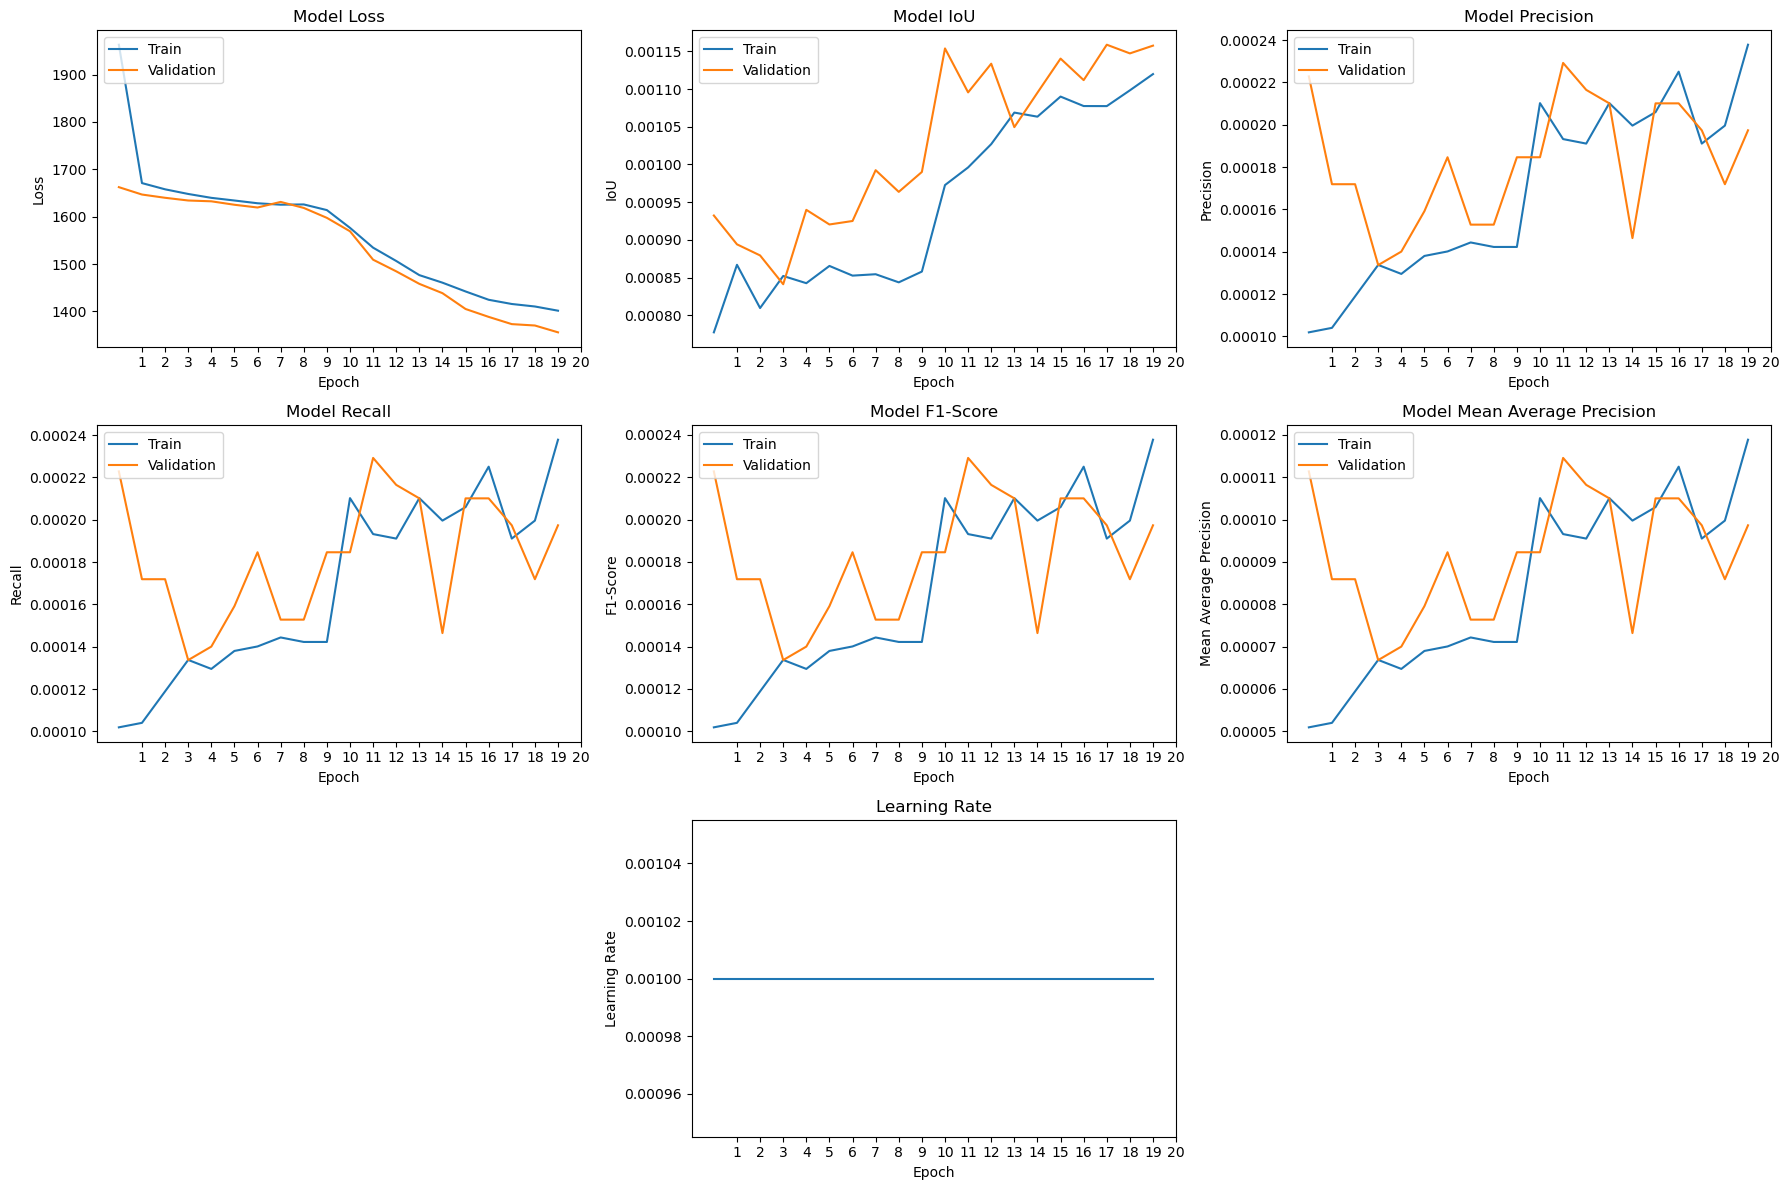

In [35]:
plot_metrics(history)

In [49]:
# Save the entire model
custom_cnn_model1.save(SAVE_PATH + 'custom_cnn_model1.keras')

In [37]:
# Load the model from a file
# custom_cnn_model1 = tf.keras.models.load_model(SAVE_PATH + 'custom_cnn_model1.keras')
gc.collect()

32076

## Custom CNN 2

In [127]:
class CustomCNNModel2:
    def __init__(self, input_shape=(IMG_SIZE, IMG_SIZE, 3), max_bboxes=max_bboxes):
        self.input_shape = input_shape
        self.num_bboxes = max_bboxes
        self.output_shape = max_bboxes * 4
        self.model = self.build_model()

    def build_model(self):
        # Check for GPU availability
        if tf.config.list_physical_devices('GPU'):
            device = '/GPU:0'
        else:
            device = '/CPU:0'
        print(f'Using device: {device}')
        
        with tf.device(device):
            model = Sequential()
            
            # First Convolutional Block
            model.add(Conv2D(32, (3, 3), activation='relu', input_shape=self.input_shape))
            model.add(MaxPooling2D((2, 2)))

            # Second Convolutional Block
            model.add(Conv2D(64, (3, 3), activation='relu'))
            model.add(MaxPooling2D((2, 2)))

            # Third Convolutional Block
            model.add(Conv2D(128, (3, 3), activation='relu'))
            model.add(MaxPooling2D((2, 2)))

            # Fourth Convolutional Block
            model.add(Conv2D(256, (3, 3), activation='relu'))
            model.add(MaxPooling2D((2, 2)))

            # Global Average Pooling instead of Flattening
            model.add(GlobalAveragePooling2D())

            # Fully Connected Layer with Dropout
            model.add(Dense(512, activation='relu'))
            model.add(Dropout(0.5))

            # Output Layer
            model.add(Dense(self.output_shape, activation='linear'))  # Output layer with 4 units for bounding box coordinates (whxy)
            model.add(Reshape((self.num_bboxes, 4)))
        return model

    def compile_model(self):
                self.model.compile(optimizer='adam',
                      loss='mse',
                      metrics=[IoU, PrecisionMetric(), RecallMetric(), F1ScoreMetric(), MeanAveragePrecision()])
        
    def train(self, train_dataset, val_dataset, epochs=EPOCHS, checkpoint_dir=CHECKPOINT_DIR):
        # Callbacks
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
        checkpoint_callback = ModelCheckpoint(filepath=os.path.join(checkpoint_dir, 'custom_cnn_model2.keras'), save_weights_only=False, monitor='val_loss', save_best_only=True, mode='min')
        log_dir = os.path.join('logs', 'CustomCNN2', 'fit', datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
        tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
        lr_logging_callback = LrLoggingCallback()
        # roc_auc_callback = RocAucCallback(validation_data=val_dataset)
        # lr_scheduler = LearningRateScheduler(self.step_decay_schedule(initial_lr=0.1, decay_factor=0.5, step_size=10))
        history = self.model.fit(train_dataset, validation_data=val_dataset, epochs=epochs,
                                 callbacks=[early_stopping, reduce_lr, checkpoint_callback, tensorboard_callback, lr_logging_callback])
        return history

    def evaluate(self, test_dataset):
        results = self.model.evaluate(test_dataset, verbose=0)
        loss, IoU_val, precision_val, recall_val, f1_score_val, map_val = results
        # lr = self.model.optimizer.learning_rate.numpy()
        
        # Predict probabilities for the validation dataset
        y_true = []
        y_pred = []
        for x, y in val_dataset:
            y_true.extend(y.numpy())
            y_pred.extend(self.model.predict(x).ravel())
        # fpr, tpr, _ = roc_curve(y_true, y_pred)
        # roc_auc = auc(fpr, tpr)
        
        print(f'Testing Loss: {loss:.4f}, IoU: {IoU_val:.4f}, Precision: {precision_val:.4f}, Recall: {recall_val:.4f}, F1-Score: {f1_score_val:.4f}, mAP: {map_val:.4f}')
        return {
            'loss': loss,
            'IoU': IoU_val,
            'precision': precision_val,
            'recall': recall_val,
            'f1_score': f1_score_val,
            'mean_average_precision': map_val
        }
    
    def save(self, path):
        self.model.save(path)

    # def step_decay_schedule(self, initial_lr=0.1, decay_factor=0.5, step_size=10):
    #     def schedule(epoch):
    #         return initial_lr * (decay_factor ** (epoch // step_size))
    #     return schedule

# Initialize the CustomCNNModel class
custom_cnn_model2 = CustomCNNModel2(input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Compile the model
custom_cnn_model2.compile_model()

custom_cnn_model2.model.summary()

Using device: /GPU:0


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_61 (Conv2D)              │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_61 (MaxPooling2D) │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_62 (Conv2D)              │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_62 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_63 (Conv2D)              │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_63 (MaxPooling2D) │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_64 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_64 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_20     │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 522,052 (1.99 MB)

 Trainable params: 522,052 (1.99 MB)

 Non-trainable params: 0 (0.00 B)

In [128]:
# Train the model
history2 = custom_cnn_model2.train(train_dataset, val_dataset, epochs=EPOCHS)

# Evaluate the model on the test set
test_loss = custom_cnn_model2.evaluate(test_dataset)

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - f1_score: 0.0000e+00 - iou: 0.0000e+00 - loss: 1389.1078 - mean_average_precision: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00Epoch 1: Learning rate is 0.0010000000474974513
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - f1_score: 0.0000e+00 - iou: 0.0000e+00 - loss: 1389.1078 - mean_average_precision: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_f1_score: 0.0000e+00 - val_iou: 0.0000e+00 - val_loss: 3295.3271 - val_mean_average_precision: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010 - lr: 0.0010
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - f1_score: 0.0000e+00 - iou: 0.0032 - loss: 673.3677 - mean_average_precision: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00Epoch 2: Learning rate is 0.0010000000474974513
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - f1_score: 0.0000e+00 - iou: 0.0032 - loss: 673.3677 - mean_average_precision: 0.0000e+00 - precision: 0.0000e+00

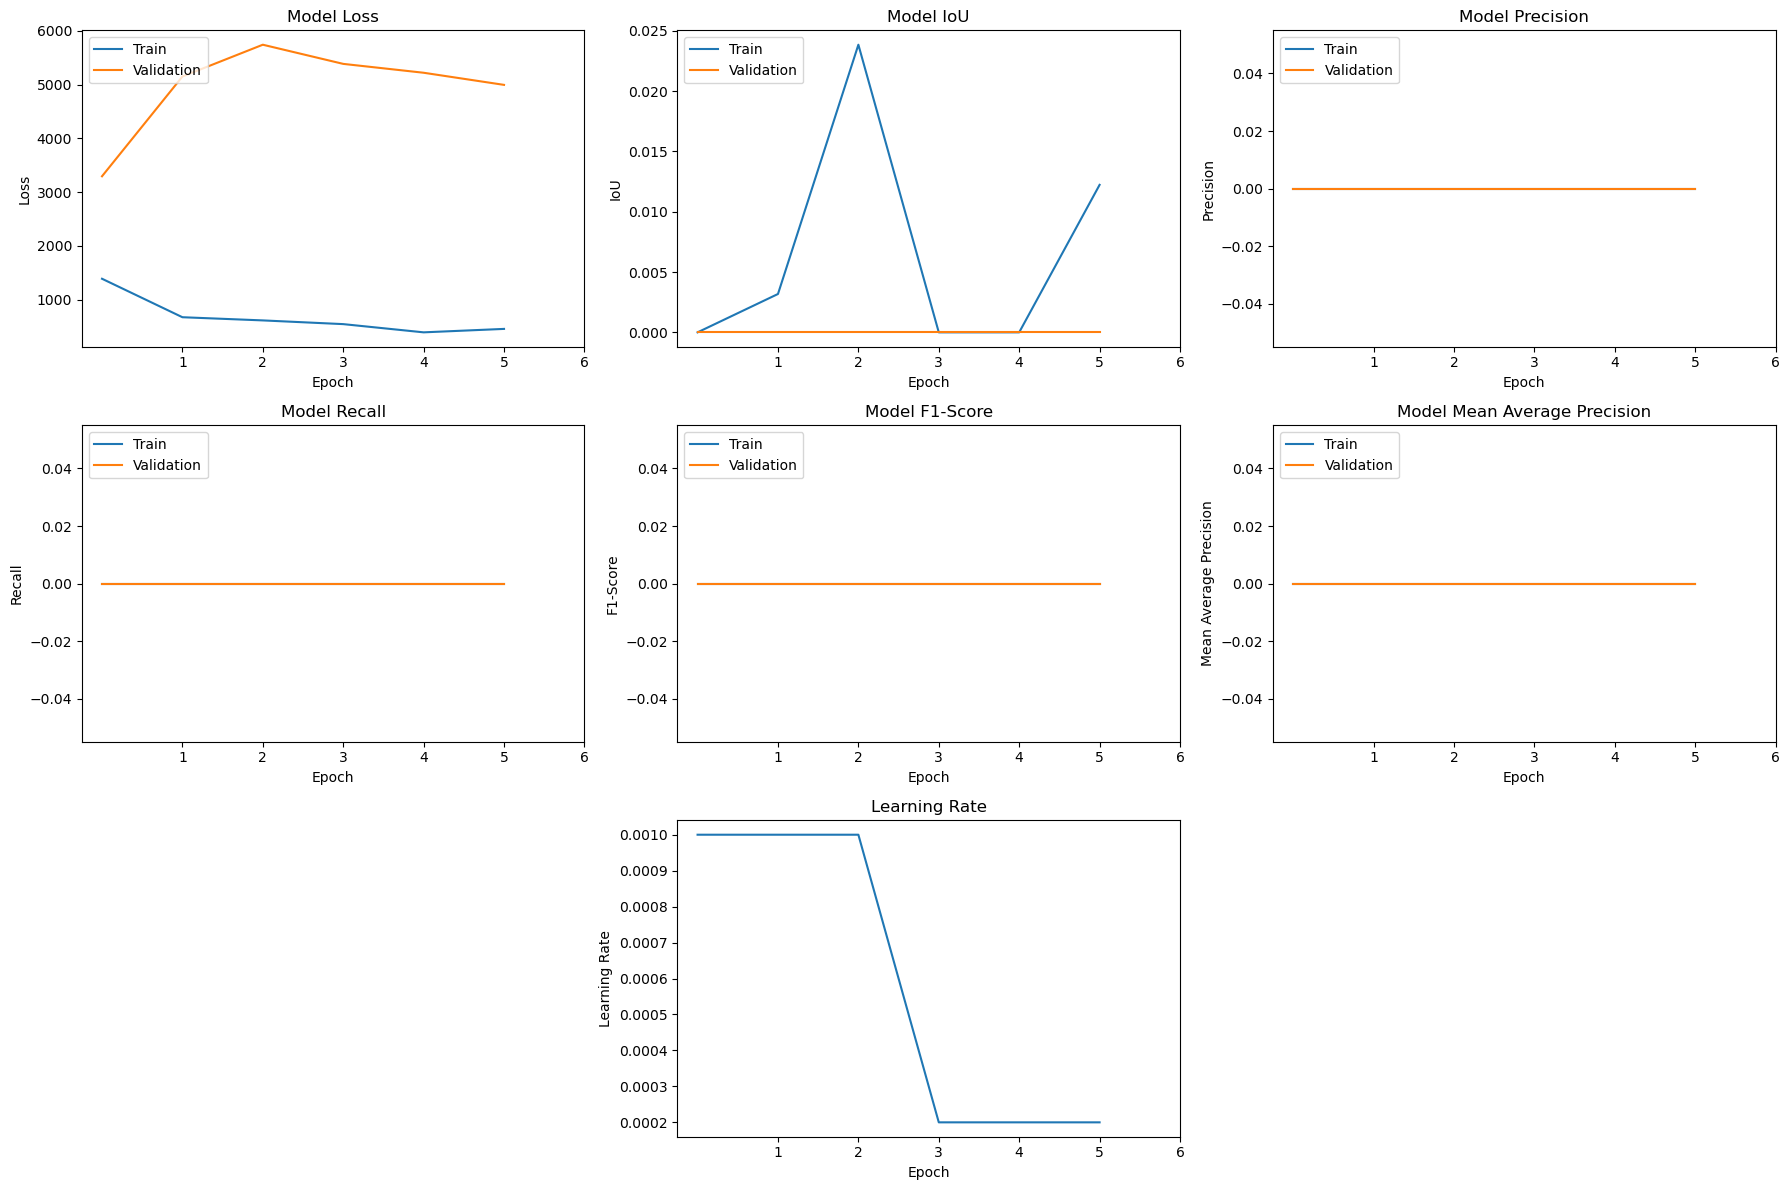

In [129]:
plot_metrics(history2)

In [130]:
# Save the entire model
custom_cnn_model2.save(SAVE_PATH + 'custom_cnn_model2.keras')

In [131]:
# Load the model from a file
# custom_cnn_model2 = tf.keras.models.load_model(SAVE_PATH + 'custom_cnn_model2.keras')
gc.collect()

29646

## Custom CNN 3

In [132]:
class CustomCNNModel3:
    def __init__(self, input_shape=(IMG_SIZE, IMG_SIZE, 3), max_bboxes=max_bboxes):
        self.input_shape = input_shape
        self.num_bboxes = max_bboxes
        self.output_shape = max_bboxes * 4
        self.model = self.build_model()

    def build_model(self):
        # Check for GPU availability
        if tf.config.list_physical_devices('GPU'):
            device = '/GPU:0'
        else:
            device = '/CPU:0'
        print(f'Using device: {device}')
        
        with tf.device(device):
            model = Sequential()
            
            # First Convolutional Block
            model.add(Conv2D(32, (3, 3), activation='relu', input_shape=self.input_shape))
            model.add(BatchNormalization())
            model.add(MaxPooling2D((2, 2)))

            # Second Convolutional Block
            model.add(Conv2D(64, (3, 3), activation='relu'))
            model.add(BatchNormalization())
            model.add(MaxPooling2D((2, 2)))

            # Third Convolutional Block
            model.add(Conv2D(128, (3, 3), activation='relu'))
            model.add(BatchNormalization())
            model.add(MaxPooling2D((2, 2)))

            # Fourth Convolutional Block
            model.add(Conv2D(256, (3, 3), activation='relu'))
            model.add(BatchNormalization())
            model.add(MaxPooling2D((2, 2)))

            # Fifth Convolutional Block
            model.add(Conv2D(512, (3, 3), activation='relu'))
            model.add(BatchNormalization())
            model.add(MaxPooling2D((2, 2)))

            # Global Average Pooling instead of Flattening
            model.add(GlobalAveragePooling2D())

            # Fully Connected Layer with Dropout
            model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))
            model.add(Dropout(0.5))

            # Output Layer
            model.add(Dense(self.output_shape, activation='linear'))  # Output layer with 4 units for bounding box coordinates (whxy)
            model.add(Reshape((self.num_bboxes, 4)))
        return model

    def compile_model(self):
                self.model.compile(optimizer='adam',
                      loss='mse',
                      metrics=[IoU, PrecisionMetric(), RecallMetric(), F1ScoreMetric(), MeanAveragePrecision()])

    def train(self, train_dataset, val_dataset, epochs=EPOCHS, checkpoint_dir=CHECKPOINT_DIR):
        # Callbacks
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
        checkpoint_callback = ModelCheckpoint(filepath=os.path.join(checkpoint_dir, 'custom_cnn_model3.keras'), save_weights_only=False, monitor='val_loss', save_best_only=True, mode='min')
        log_dir = os.path.join('logs', 'CustomCNN3', 'fit', datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
        tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
        lr_logging_callback = LrLoggingCallback()
        # roc_auc_callback = RocAucCallback(validation_data=val_dataset)
        # lr_scheduler = LearningRateScheduler(self.step_decay_schedule(initial_lr=0.1, decay_factor=0.5, step_size=10))
        history = self.model.fit(train_dataset, validation_data=val_dataset, epochs=epochs,
                                 callbacks=[early_stopping, reduce_lr, checkpoint_callback, tensorboard_callback,  lr_logging_callback])
        return history

    def evaluate(self, test_dataset):
        results = self.model.evaluate(test_dataset, verbose=0)
        loss, iou_val, precision_val, recall_val, f1_score_val, map_val = results
        # lr = self.model.optimizer.learning_rate.numpy()
        
        # Predict probabilities for the validation dataset
        y_true = []
        y_pred = []
        for x, y in val_dataset:
            y_true.extend(y.numpy())
            y_pred.extend(self.model.predict(x).ravel())
        # fpr, tpr, _ = roc_curve(y_true, y_pred)
        # roc_auc = auc(fpr, tpr)
        
        print(f'Testing Loss: {loss:.4f}, IoU: {iou_val:.4f}, Precision: {precision_val:.4f}, Recall: {recall_val:.4f}, F1-Score: {f1_score_val:.4f}, mAP: {map_val:.4f}')
        return {
            'loss': loss,
            'iou': iou_val,
            'precision': precision_val,
            'recall': recall_val,
            'f1_score': f1_score_val,
            'mean_average_precision': map_val
        }
    
    def save(self, path):
        self.model.save(path)
        
    # def step_decay_schedule(self, initial_lr=0.1, decay_factor=0.5, step_size=10):
    #     def schedule(epoch):
    #         return initial_lr * (decay_factor ** (epoch // step_size))
    #     return schedule

# Initialize the CustomCNNModel class
custom_cnn_model3 = CustomCNNModel3(input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Compile the model
custom_cnn_model3.compile_model()

custom_cnn_model3.model.summary()

Using device: /GPU:0


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_65 (Conv2D)              │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_65 (MaxPooling2D) │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_66 (Conv2D)              │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_66 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_67 (Conv2D)              │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_67 (MaxPooling2D) │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_68 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_68 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_69 (Conv2D)              │ (None, 12, 12, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_69 (MaxPooling2D) │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_21     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,837,252 (7.01 MB)

 Trainable params: 1,835,268 (7.00 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [133]:
# Train the model
history3 = custom_cnn_model3.train(train_dataset, val_dataset, epochs=EPOCHS)

# Evaluate the model on the test set
test_loss = custom_cnn_model3.evaluate(test_dataset)

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - f1_score: 0.0000e+00 - iou: 0.0000e+00 - loss: 1381.7554 - mean_average_precision: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00Epoch 1: Learning rate is 0.0010000000474974513
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - f1_score: 0.0000e+00 - iou: 0.0000e+00 - loss: 1381.7554 - mean_average_precision: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_f1_score: 0.0000e+00 - val_iou: 0.0000e+00 - val_loss: 8003.0884 - val_mean_average_precision: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010 - lr: 0.0010
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - f1_score: 0.0000e+00 - iou: 0.0000e+00 - loss: 1141.0226 - mean_average_precision: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00Epoch 2: Learning rate is 0.0010000000474974513
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 782ms/step - f1_score: 0.0000e+00 - iou: 0.0000e+00 - loss: 1141.0226 - mean_average_precision: 0.0000e+00 - precision: 

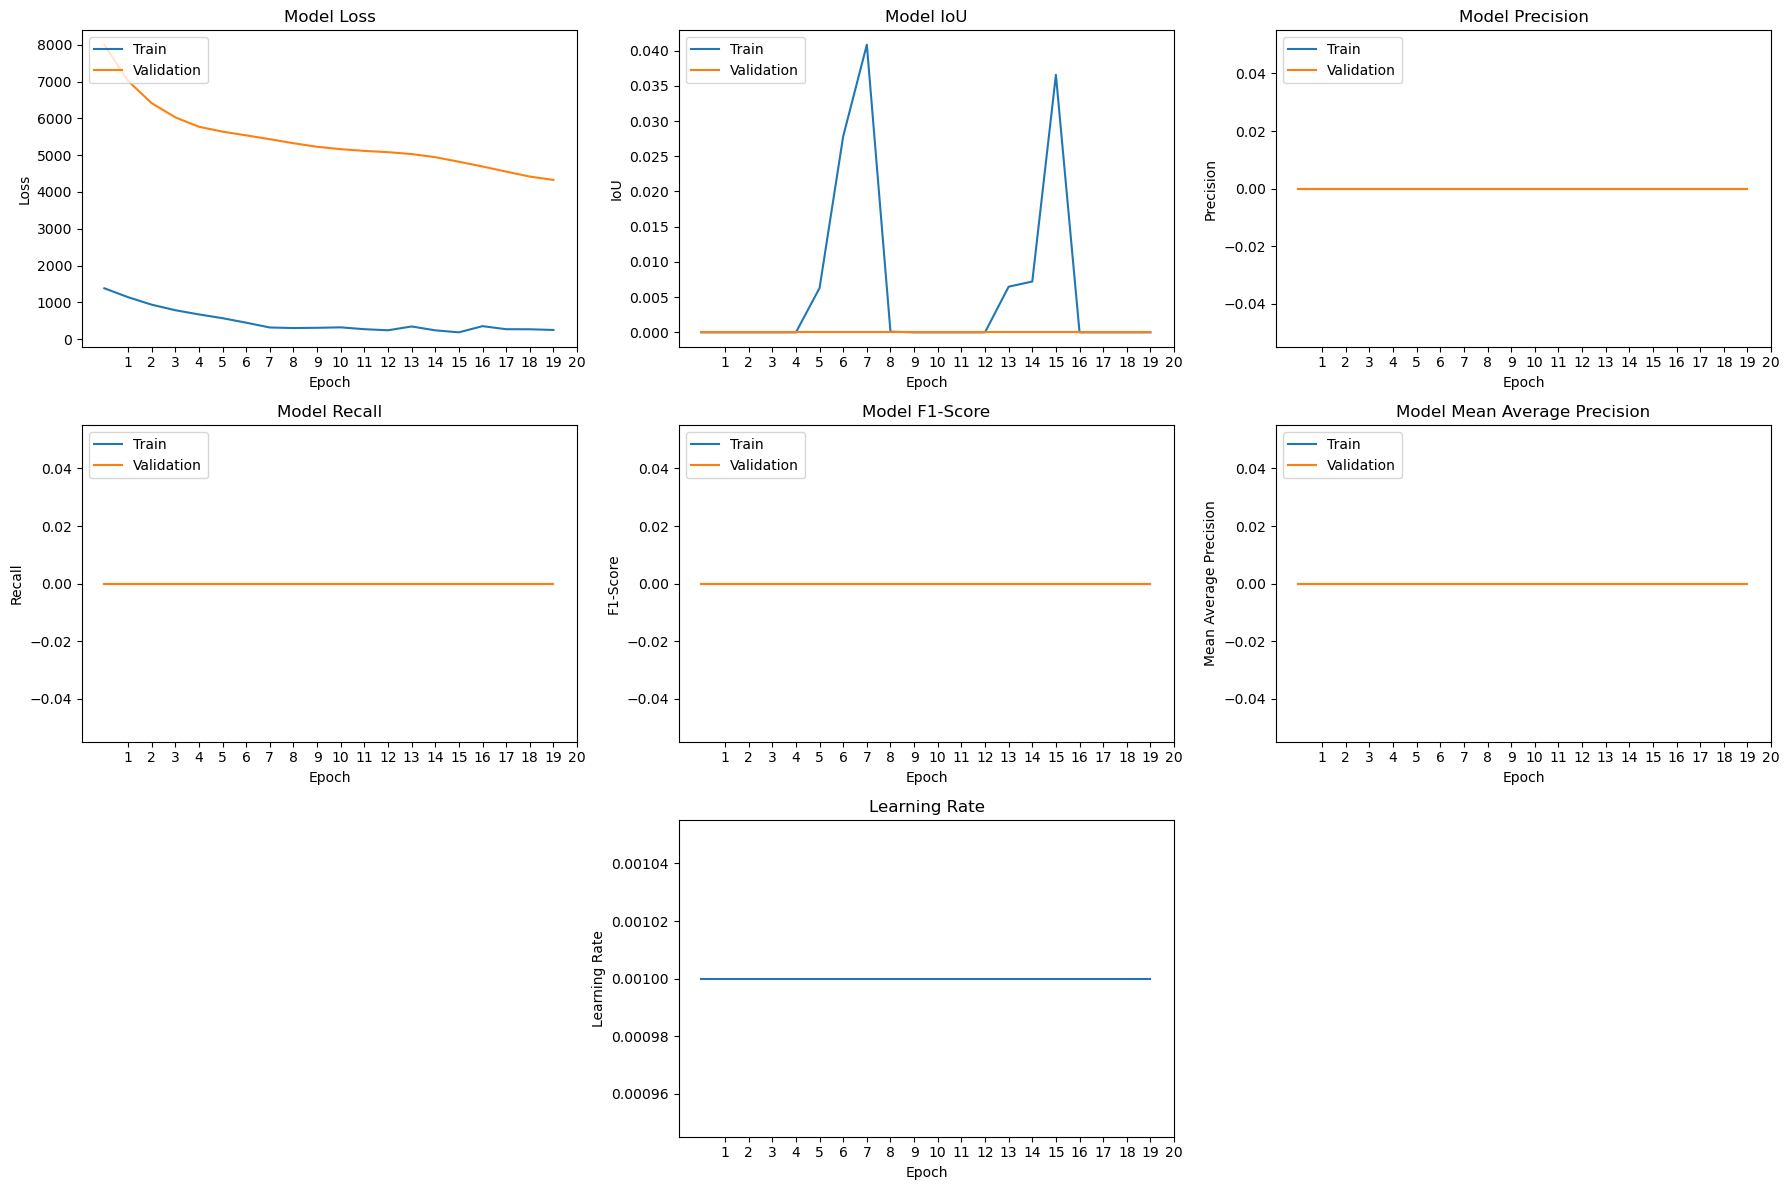

In [134]:
plot_metrics(history3)

In [135]:
# Save the entire model
custom_cnn_model3.save(SAVE_PATH + 'custom_cnn_model3.keras')

In [136]:
# Load the model from a file
# custom_cnn_model3 = tf.keras.models.load_model(SAVE_PATH + 'custom_cnn_model3.keras')
gc.collect()

29420

# Saving History

In [137]:
import pickle

with open('training_history_1.pkl', 'wb') as file:
    pickle.dump(history.history, file)

with open('training_history_2.pkl', 'wb') as file:
    pickle.dump(history2.history, file)
    
with open('training_history_3.pkl', 'wb') as file:
    pickle.dump(history3.history, file)

Using device: /GPU:0


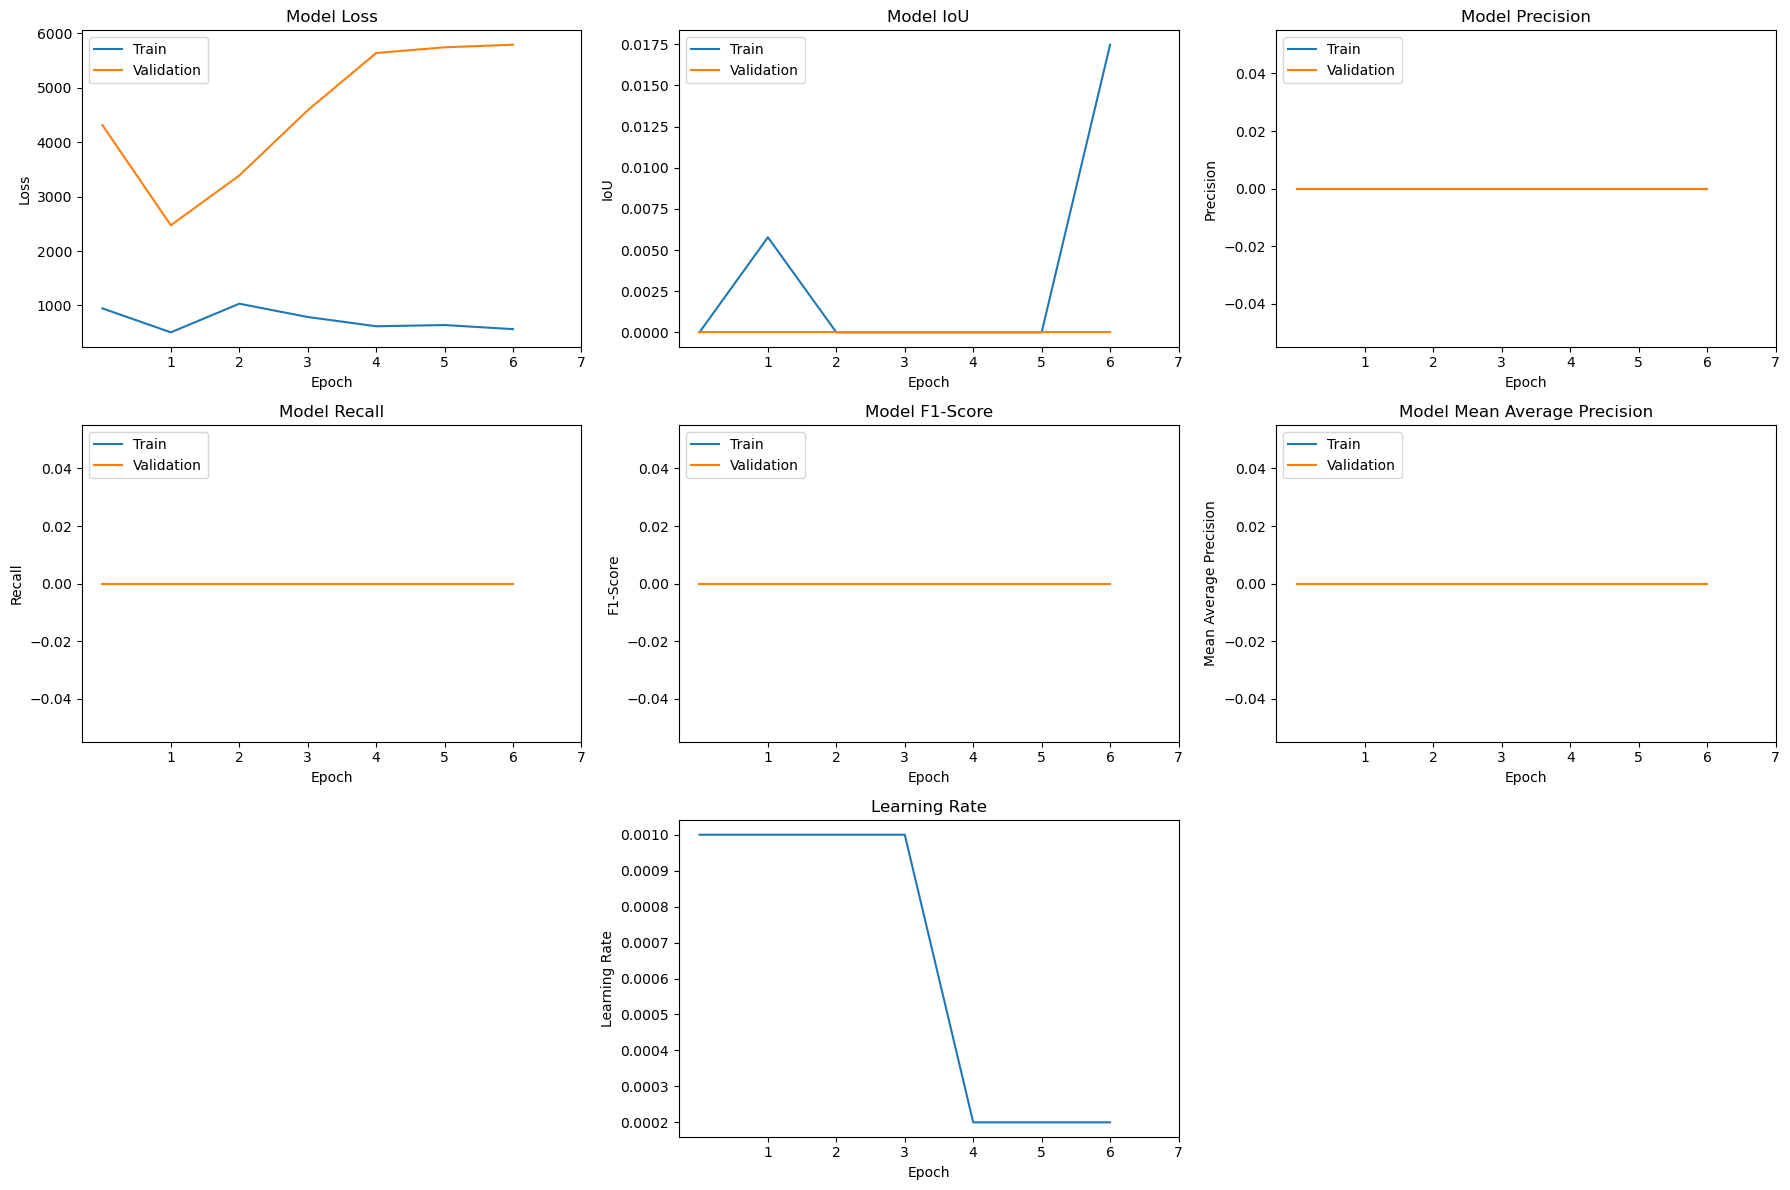

In [138]:
with open('training_history_1.pkl', 'rb') as file:
    loaded_history = pickle.load(file)

model = CustomCNNModel1(input_shape=(IMG_SIZE, IMG_SIZE, 3))
model.compile_model()
# Train the model for zero epochs to get an empty history object
empty_history = model.train(train_dataset, val_dataset, epochs=0)

# Set the loaded history to the empty history object
empty_history.history = loaded_history

# Now empty_history contains the loaded history
plot_metrics(empty_history)

Using device: /GPU:0


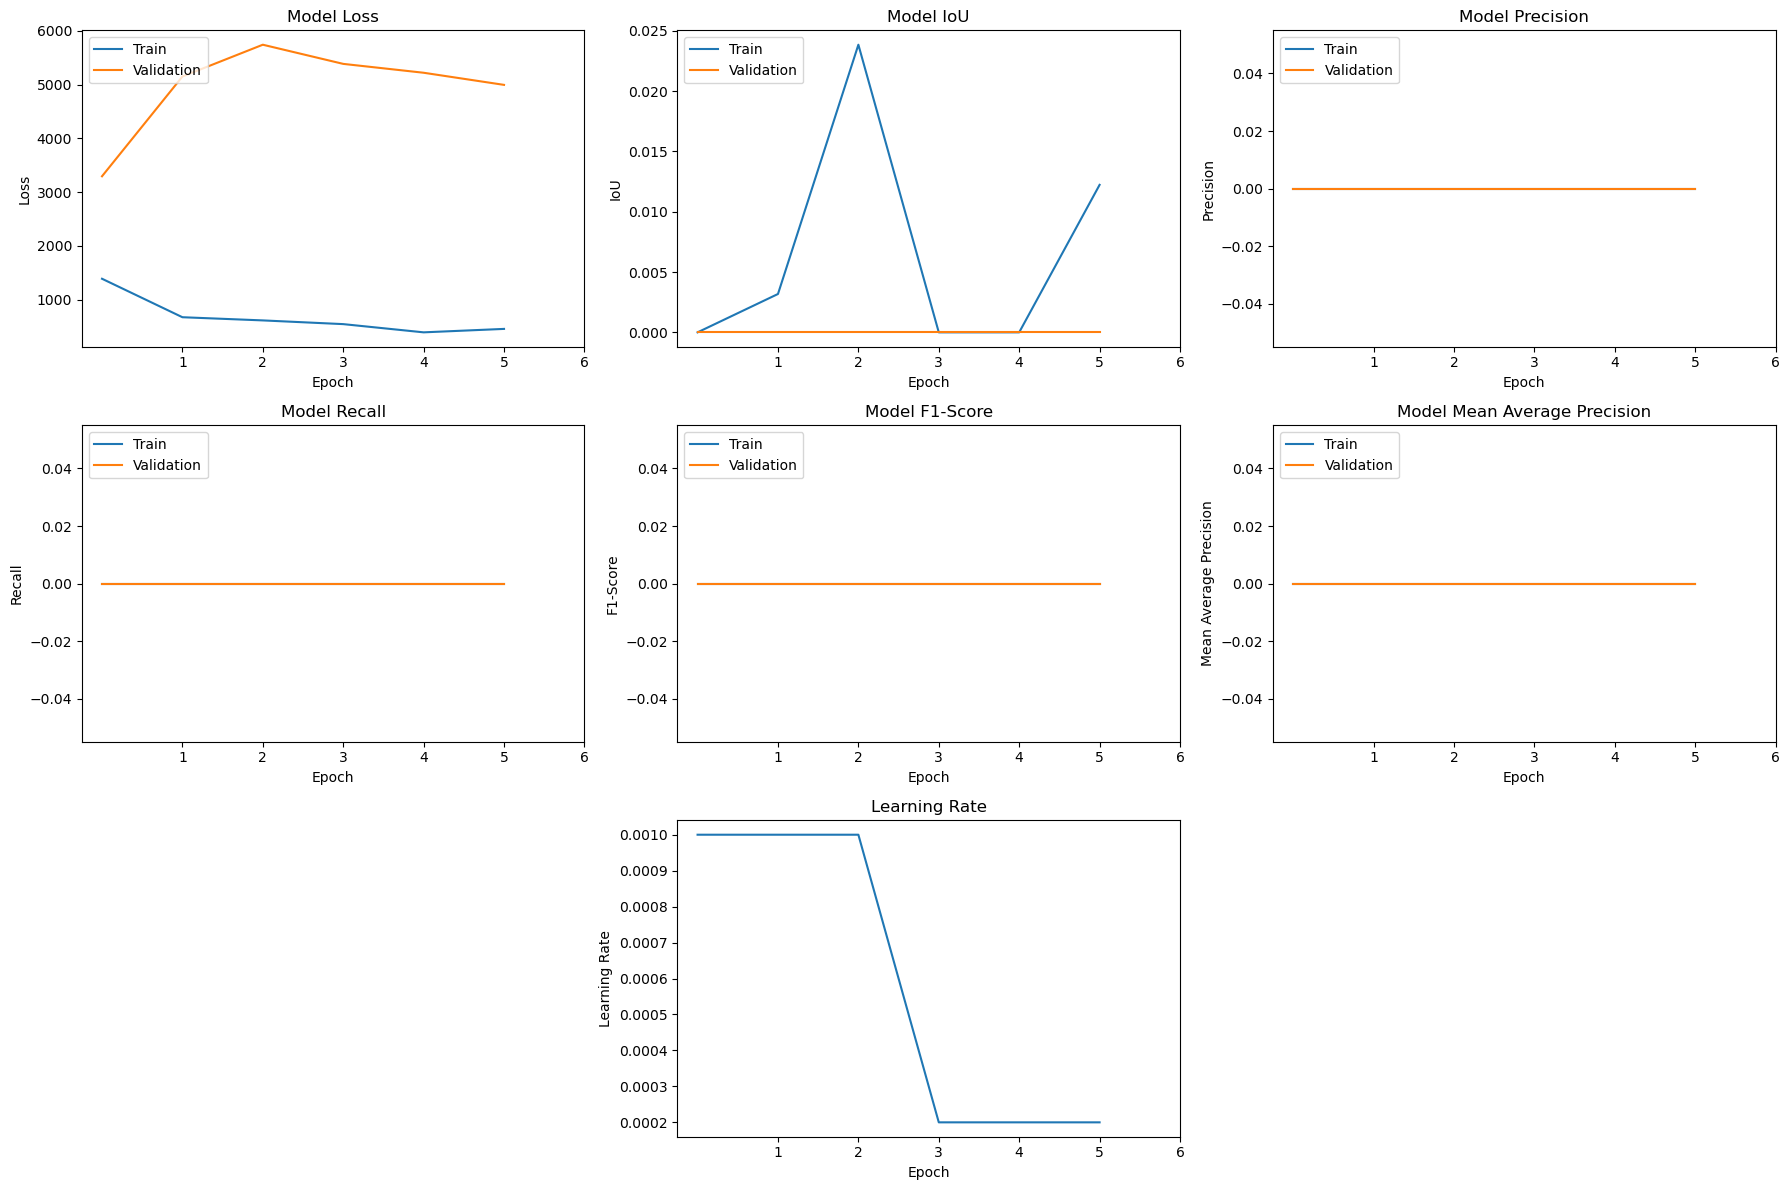

In [139]:
with open('training_history_2.pkl', 'rb') as file:
    loaded_history = pickle.load(file)

model = CustomCNNModel2(input_shape=(IMG_SIZE, IMG_SIZE, 3))
model.compile_model()
# Train the model for zero epochs to get an empty history object
empty_history = model.train(train_dataset, val_dataset, epochs=0)

# Set the loaded history to the empty history object
empty_history.history = loaded_history

# Now empty_history contains the loaded history
plot_metrics(empty_history)

Using device: /GPU:0


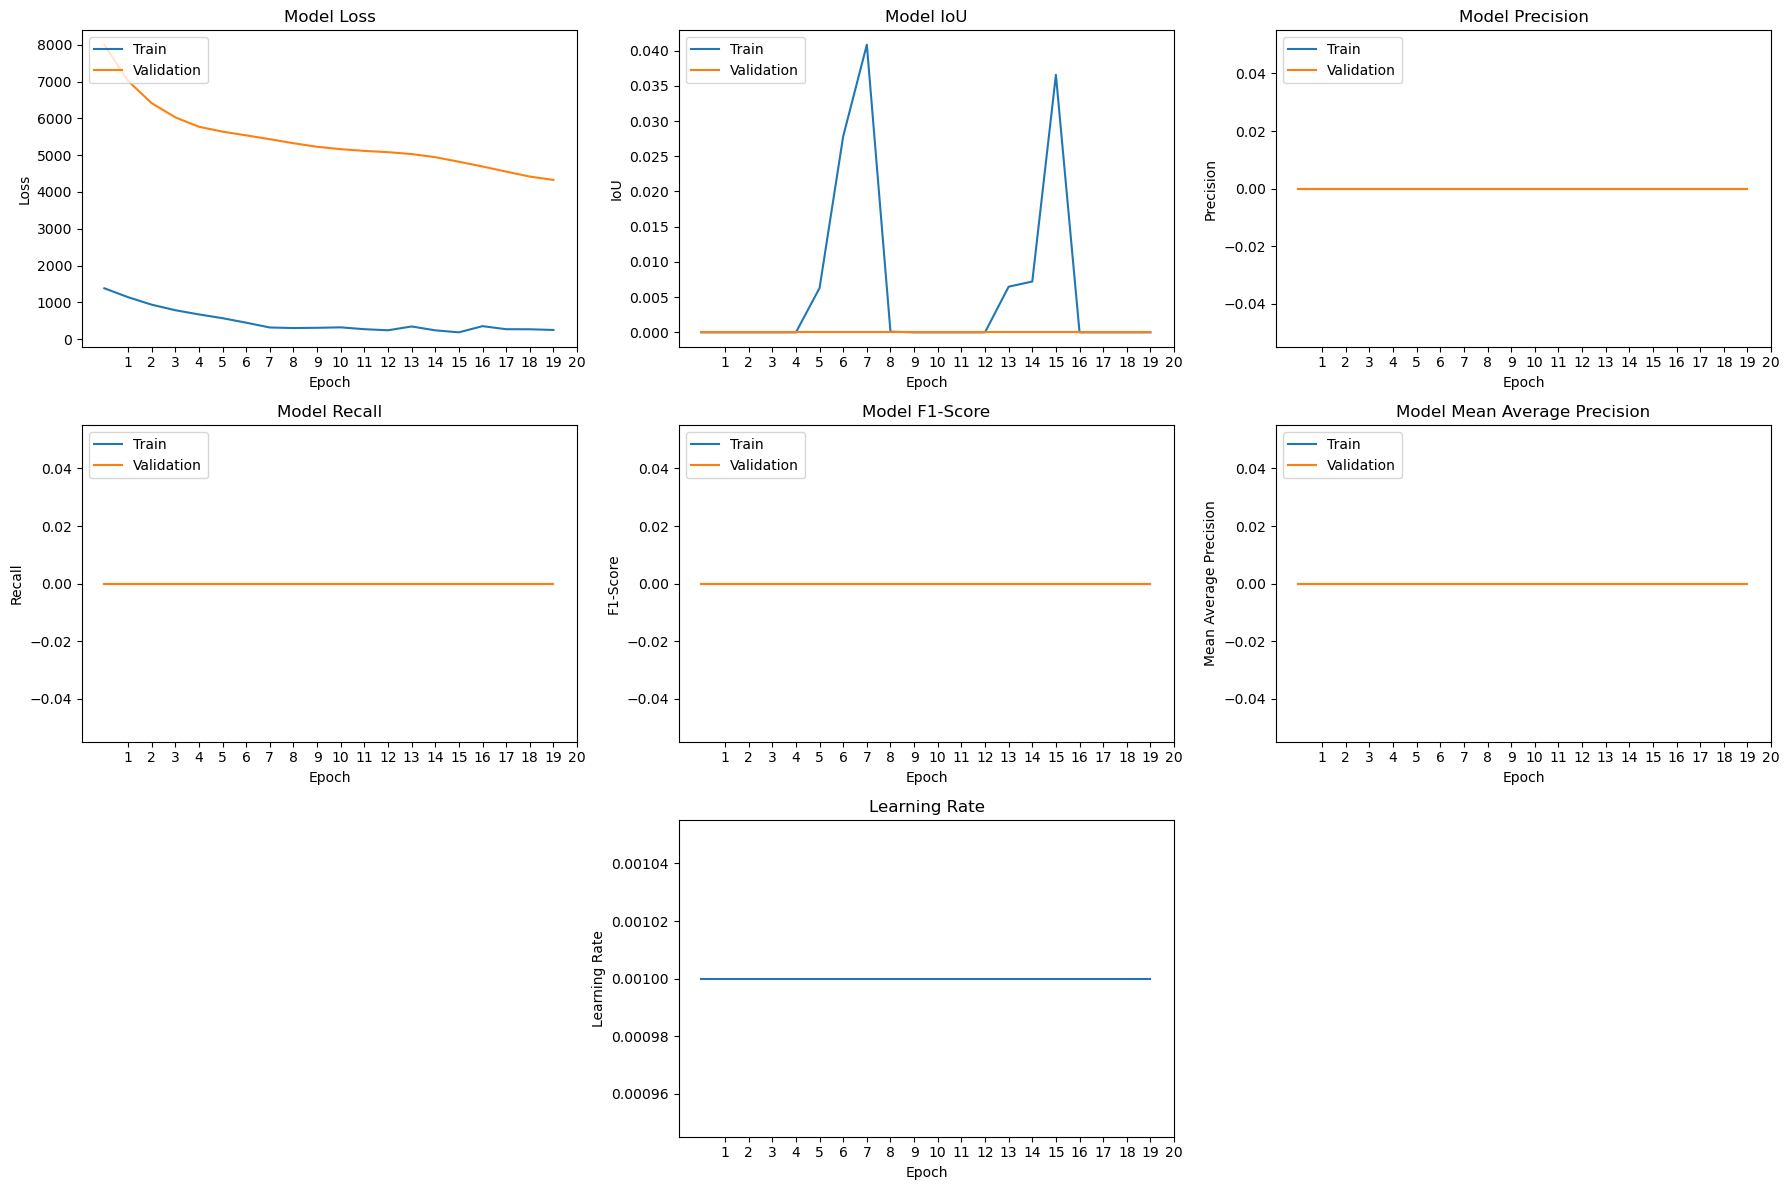

In [140]:
with open('training_history_3.pkl', 'rb') as file:
    loaded_history = pickle.load(file)

model = CustomCNNModel3(input_shape=(IMG_SIZE, IMG_SIZE, 3))
model.compile_model()
# Train the model for zero epochs to get an empty history object
empty_history = model.train(train_dataset, val_dataset, epochs=0)

# Set the loaded history to the empty history object
empty_history.history = loaded_history

# Now empty_history contains the loaded history
plot_metrics(empty_history)

# Hyperparameter tuning for Custom CNN 1

In [159]:
class CustomCNNHyperModel(HyperModel):
    def __init__(self, input_shape=(IMG_SIZE, IMG_SIZE, 3), max_bboxes=max_bboxes):
        self.input_shape = input_shape
        self.num_bboxes = max_bboxes
        self.output_shape = max_bboxes * 4

    def build(self, hp):
        model = Sequential()
        
        # First Convolutional Block
        model.add(Conv2D(32, (3, 3), activation='relu', input_shape=self.input_shape))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))

        # Second Convolutional Block
        model.add(Conv2D(64, (3, 3), activation='relu')),
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))

        # Third Convolutional Block
        model.add(Conv2D(hp.Int('conv_5_filters', min_value=128, max_value=256, step=128), (3, 3), activation='relu')),
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))

        # Global Average Pooling instead of Flattening
        model.add(GlobalAveragePooling2D())

        # Fully Connected Layer with Dropout
        model.add(Dense(1024, activation='relu', kernel_regularizer=l2(0.001))),
        model.add(Dropout(hp.Float('dropout_rate', min_value=0.4, max_value=0.5, step=0.1)))

        # Output Layer
        model.add(Dense(self.output_shape, activation='linear'))  # Output layer with 4 units for bounding box coordinates (whxy)
        model.add(Reshape((self.num_bboxes, 4)))

        # Compile the model
        learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=5e-3, sampling='LOG')
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                        loss='mse',
                        metrics=[IoU, PrecisionMetric(), RecallMetric(), F1ScoreMetric(), MeanAveragePrecision()])
        return model
    
    def evaluate(self, test_dataset):
        results = self.model.evaluate(test_dataset, verbose=0)
        loss, IoU_val, precision_val, recall_val, f1_score_val, map_val = results
        # lr = self.model.optimizer.learning_rate.numpy()
        
        # Predict probabilities for the validation dataset
        y_true = []
        y_pred = []
        for x, y in val_dataset:
            y_true.extend(y.numpy())
            y_pred.extend(self.model.predict(x).ravel())
        # fpr, tpr, _ = roc_curve(y_true, y_pred)
        # roc_auc = auc(fpr, tpr)
        
        print(f'Testing Loss: {loss:.4f}, IoU: {IoU_val:.4f}, Precision: {precision_val:.4f}, Recall: {recall_val:.4f}, F1-Score: {f1_score_val:.4f}, mAP: {map_val:.4f}')
        return {
            'loss': loss,
            'IoU': IoU_val,
            'precision': precision_val,
            'recall': recall_val,
            'f1_score': f1_score_val,
            'mean_average_precision': map_val
        }
    
    def save(self, path):
        self.model.save(path)

# Initialize the hypermodel
hypermodel = CustomCNNHyperModel(input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Initialize the tuner
tuner = Hyperband(
    hypermodel,
    objective='val_loss',
    # max_epochs=2, 
    max_epochs=EPOCHS,
    factor=3, 
    directory='hyperparameter_tuning',
    project_name='custom_cnn_model1',
    overwrite=True
)

# Display search space summary
tuner.search_space_summary()

# Create TensorFlow Datasets with smaller batch size
train_dataset = create_dataset(train_paths, train_bboxes, batch_size=32)
val_dataset = create_dataset(val_paths, val_bboxes, batch_size=32)
test_dataset = create_dataset(test_paths, test_bboxes, batch_size=32)

train_dataset = train_dataset.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.float32)))
val_dataset = val_dataset.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.float32)))
test_dataset = test_dataset.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.float32)))

# Run the hyperparameter search
tuner.search(train_dataset, validation_data=val_dataset, epochs=EPOCHS)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model
best_model.evaluate(test_dataset)

# Display the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hyperparameters.values)

# Retrieve the best optimizer
best_lr = best_hyperparameters.get('learning_rate')
print(f"Best optimizer: {best_lr}")

Trial 30 Complete [00h 00m 18s]
val_loss: 7901.48828125

Best val_loss So Far: 802.6051635742188
Total elapsed time: 00h 07m 24s
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - f1_score: 0.0000e+00 - iou: 0.0000e+00 - loss: 4651.3828 - mean_average_precision: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00
{'conv_5_filters': 256, 'dropout_rate': 0.4, 'learning_rate': 0.0026106016329996277, 'tuner/epochs': 10, 'tuner/initial_epoch': 4, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0013'}
Best optimizer: 0.0026106016329996277


In [157]:
# Build the model using the best hyperparameters
best_model = tuner.hypermodel.build(best_hyperparameters)

# Create the optimizer with the best learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=best_lr)

# Compile the model with the optimizer
best_model.compile(optimizer=optimizer,
                          loss='mse',
                          metrics=[IoU, PrecisionMetric(), RecallMetric(), F1ScoreMetric(), MeanAveragePrecision()])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
checkpoint_callback = ModelCheckpoint(filepath=os.path.join(CHECKPOINT_DIR, 'custom_cnn_model3.keras'), save_weights_only=False, monitor='val_loss', save_best_only=True, mode='min')
log_dir = os.path.join('logs', 'bestCustomCNN1', 'fit', datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
lr_logging_callback = LrLoggingCallback()
# roc_auc_callback = RocAucCallback(validation_data=val_dataset)

# Train the model on the full dataset
history_best = best_model.fit(train_dataset, epochs=EPOCHS, batch_size=32, validation_data=val_dataset, callbacks=[early_stopping, reduce_lr, checkpoint_callback, tensorboard_callback,  lr_logging_callback])

# Evaluate the best model
result = best_model.evaluate(test_dataset)
print(f'Best model testing Loss: {result[0]}, IoU: {result[1]}, Testing precision: {result[2]}, Testing Recall: {result[3]}, Testing f1 score: {result[4]}, Testing mAP: {result[5]}')

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - f1_score: 0.0000e+00 - iou: 0.0000e+00 - loss: 1401.0977 - mean_average_precision: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00Epoch 1: Learning rate is 0.0031014434061944485
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - f1_score: 0.0000e+00 - iou: 0.0000e+00 - loss: 1401.0977 - mean_average_precision: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_f1_score: 0.0000e+00 - val_iou: 0.0000e+00 - val_loss: 5125.5688 - val_mean_average_precision: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0031 - lr: 0.0031
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - f1_score: 0.0000e+00 - iou: 0.0000e+00 - loss: 1206.8030 - mean_average_precision: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00Epoch 2: Learning rate is 0.0031014434061944485
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 804ms/step - f1_score: 0.0000e+00 - iou: 0.0000e+00 - loss: 1206.8030 - mean_average_precision: 0.0000e+00 - precision: 

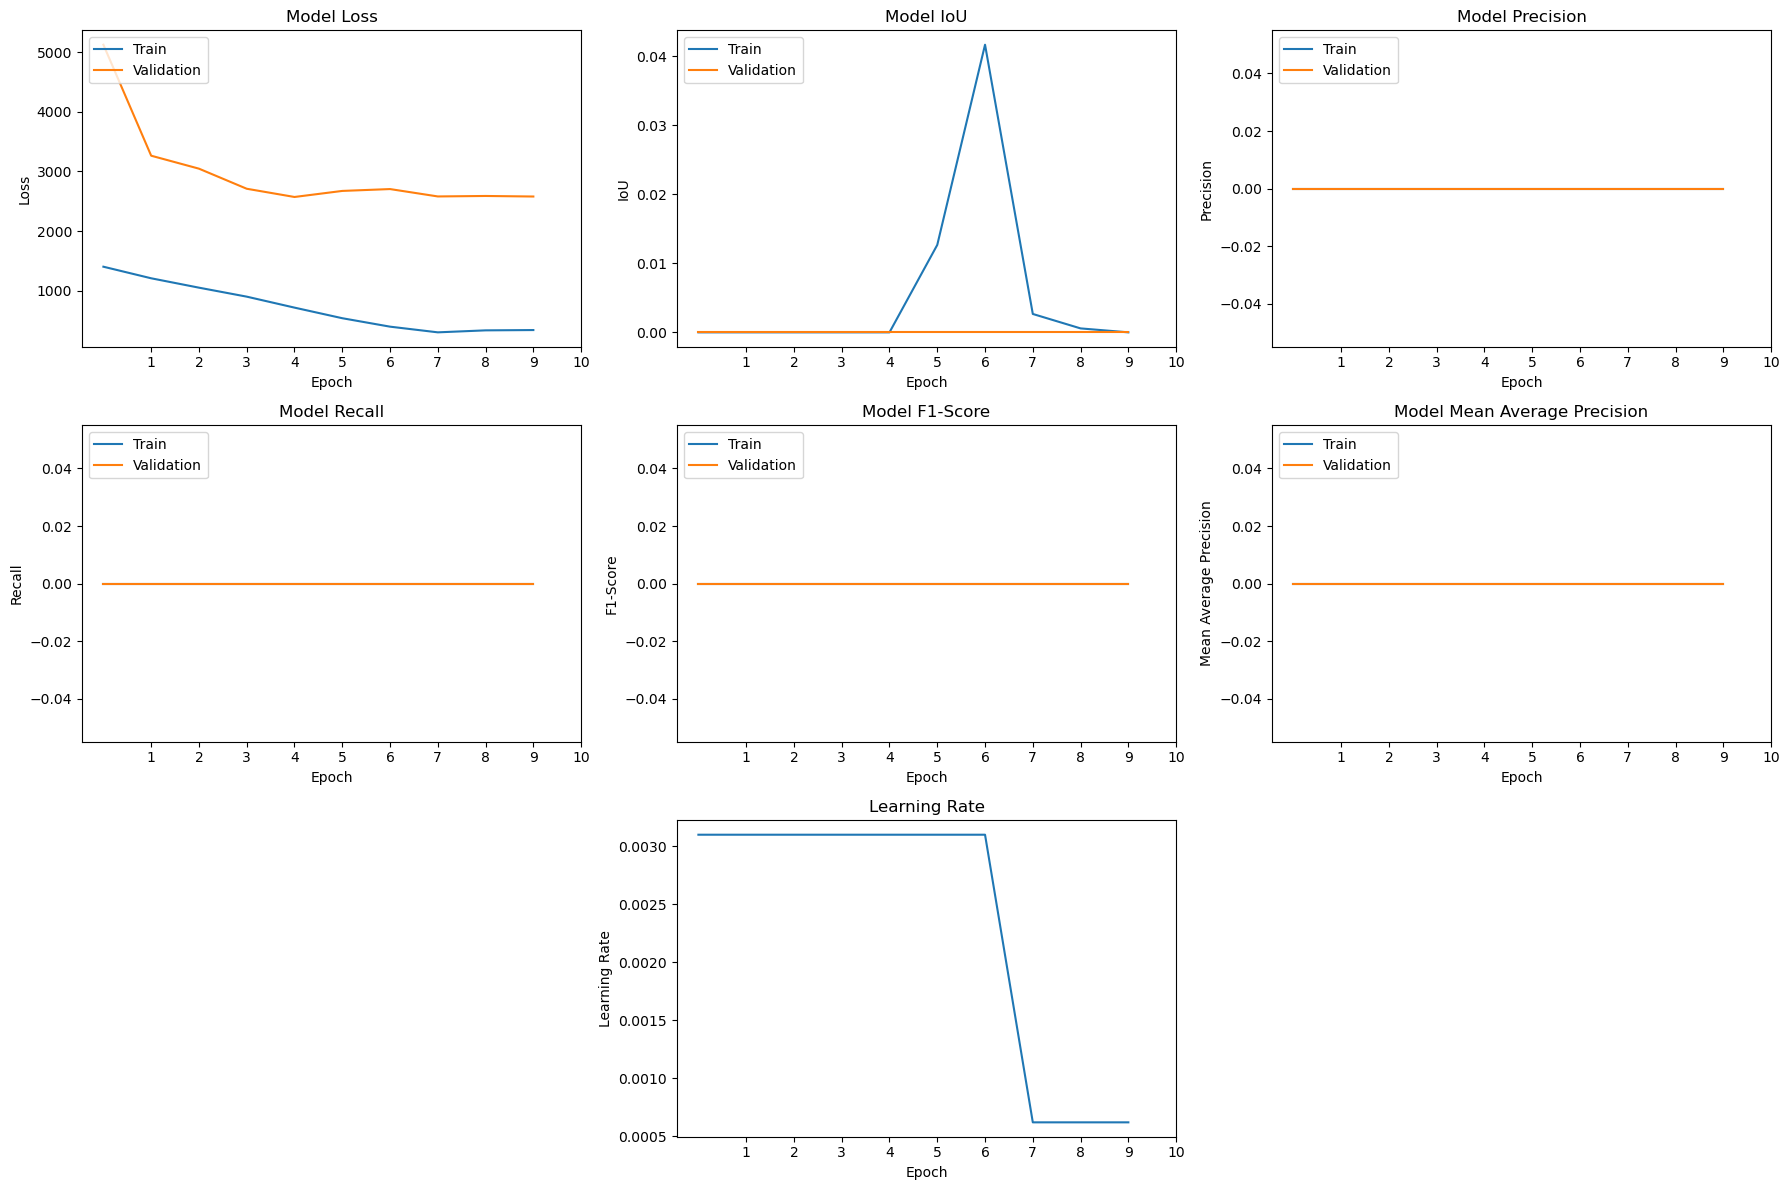

In [158]:
plot_metrics(history_best)

In [ ]:
best_model.save(SAVE_PATH + 'best_custom_cnn_model1.keras')

# Hyperparameter tuning for Custom CNN 3

In [ ]:
class CustomCNNHyperModel(HyperModel):
    def __init__(self, input_shape=(IMG_SIZE, IMG_SIZE, 3), max_bboxes=max_bboxes):
        self.input_shape = input_shape
        self.num_bboxes = max_bboxes
        self.output_shape = max_bboxes * 4

    def build(self, hp):
        model = Sequential()
        
        # First Convolutional Block
        model.add(Conv2D(32, (3, 3), activation='relu', input_shape=self.input_shape))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))

        # Second Convolutional Block
        model.add(Conv2D(64, (3, 3), activation='relu', input_shape=self.input_shape))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))

        # Third Convolutional Block
        model.add(Conv2D(128, (3, 3), activation='relu', input_shape=self.input_shape))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))

        # Fourth Convolutional Block
        model.add(Conv2D(1024, (3, 3), activation='relu')),
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))

        # Fifth Convolutional Block
        model.add(Conv2D(hp.Int('conv_5_filters', min_vale=512, max_value=1024, step=512), 
                         (3, 3), activation='relu')),
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))

        # Global Average Pooling instead of Flattening
        model.add(GlobalAveragePooling2D())

        # Fully Connected Layer with Dropout
        model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001))),
        model.add(Dropout(hp.Float('dropout_rate', min_value=0.3, max_value=0.5, step=0.1)))

        # Output Layer
        model.add(Dense(self.output_shape, activation='linear'))  # Output layer with 4 units for bounding box coordinates (whxy)
        model.add(Reshape((self.num_bboxes, 4)))

        # Compile the model
        learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=5e-3, sampling='LOG')
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                        loss='mse',
                        metrics=[IoU, PrecisionMetric(), RecallMetric(), F1ScoreMetric(), MeanAveragePrecision()])
        return model
    
    def evaluate(self, test_dataset):
        results = self.model.evaluate(test_dataset, verbose=0)
        loss, IoU_val, precision_val, recall_val, f1_score_val, map_val = results
        # lr = self.model.optimizer.learning_rate.numpy()
        print(f'Testing Loss: {loss:.4f}, IoU: {IoU_val:.4f}, Precision: {precision_val:.4f}, Recall: {recall_val:.4f}, F1-Score: {f1_score_val:.4f}, mAP: {map_val:.4f}')
        return {
            'loss': loss,
            'IoU': IoU_val,
            'precision': precision_val,
            'recall': recall_val,
            'f1_score': f1_score_val,
            'mean_average_precision': map_val
        }
    
    def save(self, path):
        self.model.save(path)

# Initialize the hypermodel
hypermodel = CustomCNNHyperModel(input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Initialize the tuner
tuner = Hyperband(
    hypermodel,
    objective='val_loss',
    # max_epochs=2, 
    max_epochs=EPOCHS,  
    factor=3, 
    directory='hyperparameter_tuning',
    project_name='custom_cnn_model2',
    overwrite=True
)

# Display search space summary
tuner.search_space_summary()

# Create TensorFlow Datasets with smaller batch size
train_dataset = create_dataset(train_paths, train_bboxes, batch_size=32)
val_dataset = create_dataset(val_paths, val_bboxes, batch_size=32)
test_dataset = create_dataset(test_paths, test_bboxes, batch_size=32)

train_dataset = train_dataset.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.float32)))
val_dataset = val_dataset.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.float32)))
test_dataset = test_dataset.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.float32)))

# Run the hyperparameter search
tuner.search(train_dataset, validation_data=val_dataset, epochs=EPOCHS)

# Get the best model
best_model2 = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model
best_model2.evaluate(test_dataset)

# Display the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hyperparameters.values)

# Retrieve the best optimizer
best_lr = best_hyperparameters.get('learning_rate')
print(f"Best optimizer: {best_lr}")


Trial 26 Complete [02h 58m 01s]
val_loss: 9906.8388671875

Best val_loss So Far: 2905.125732421875
Total elapsed time: 1d 17h 07m 04s

Search: Running Trial #27

Value             |Best Value So Far |Hyperparameter
768               |512               |conv_4_filters
relu              |sigmoid           |conv_4_activation
512               |512               |conv_5_filters
sigmoid           |relu              |conv_5_activation
1024              |256               |dense_units
relu              |relu              |dense_activation
0.2               |0.3               |dropout_rate
adam              |sgd               |optimizer
0.001753          |0.00021           |learning_rate
20                |20                |tuner/epochs
0                 |7                 |tuner/initial_epoch
0                 |2                 |tuner/bracket
0                 |2                 |tuner/round

Epoch 1/20
6355/6355 [==============================] - 961s 151ms/step - loss: 3003.1411 - iou: 0.

KeyboardInterrupt: 

In [ ]:
# Build the model using the best hyperparameters
best_model2 = tuner.hypermodel.build(best_hyperparameters)

# Create the optimizer with the best learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=best_lr)

# Compile the model with the optimizer
best_model2.compile(optimizer=optimizer,
                          loss='mse',
                          metrics=[IoU, PrecisionMetric(), RecallMetric(), F1ScoreMetric(), MeanAveragePrecision()])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
checkpoint_callback = ModelCheckpoint(filepath=os.path.join(CHECKPOINT_DIR, 'custom_cnn_model3.keras'), save_weights_only=False, monitor='val_loss', save_best_only=True, mode='min')
log_dir = os.path.join('logs', 'bestCustomCNN1', 'fit', datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
lr_logging_callback = LrLoggingCallback()
# roc_auc_callback = RocAucCallback(validation_data=val_dataset)

# Train the model on the full dataset
history_best2 = best_model.fit(train_dataset, epochs=EPOCHS, batch_size=32, validation_data=val_dataset, callbacks=[early_stopping, reduce_lr, checkpoint_callback, tensorboard_callback,  lr_logging_callback])

# Evaluate the best model
result = best_model.evaluate(test_dataset)
print(f'Best model testing Loss: {result[0]}, IoU: {result[1]}, Testing precision: {result[2]}, Testing Recall: {result[3]}, Testing f1 score: {result[4]}, Testing mAP: {result[5]}')

Best learning rate: 0.0029994788478703836
{'conv_3_filters': 256, 'conv_3_activation': 'sigmoid', 'conv_4_filters': 256, 'conv_4_activation': 'sigmoid', 'conv_5_filters': 512, 'conv_5_activation': 'relu', 'dense_units': 512, 'dense_activation': 'relu', 'dropout_rate': 0.2, 'optimizer': 'rmsprop', 'learning_rate': 0.0029994788478703836, 'tuner/epochs': 7, 'tuner/initial_epoch': 0, 'tuner/bracket': 1, 'tuner/round': 0}
Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - f1_score: 0.8532 - iou: 0.0252 - loss: 1330.3479 - mean_average_precision: 0.0252 - precision_2: 1.0000 - recall_2: 0.4348 - val_f1_score: 0.8531 - val_iou: 0.1122 - val_loss: 7301.5957 - val_mean_average_precision: 0.1122 - val_precision_2: 0.6667 - val_recall_2: 0.6667
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - f1_score: 0.8530 - iou: 0.1442 - loss: 1042.1229 - mean_average_precision: 0.1442 - precision_2: 0.9444 - recall_2: 0.7391 - val_f1_score: 0.8528 - val_iou: 0.2630 - val_loss: 4818.9575 - val_mean_average_p

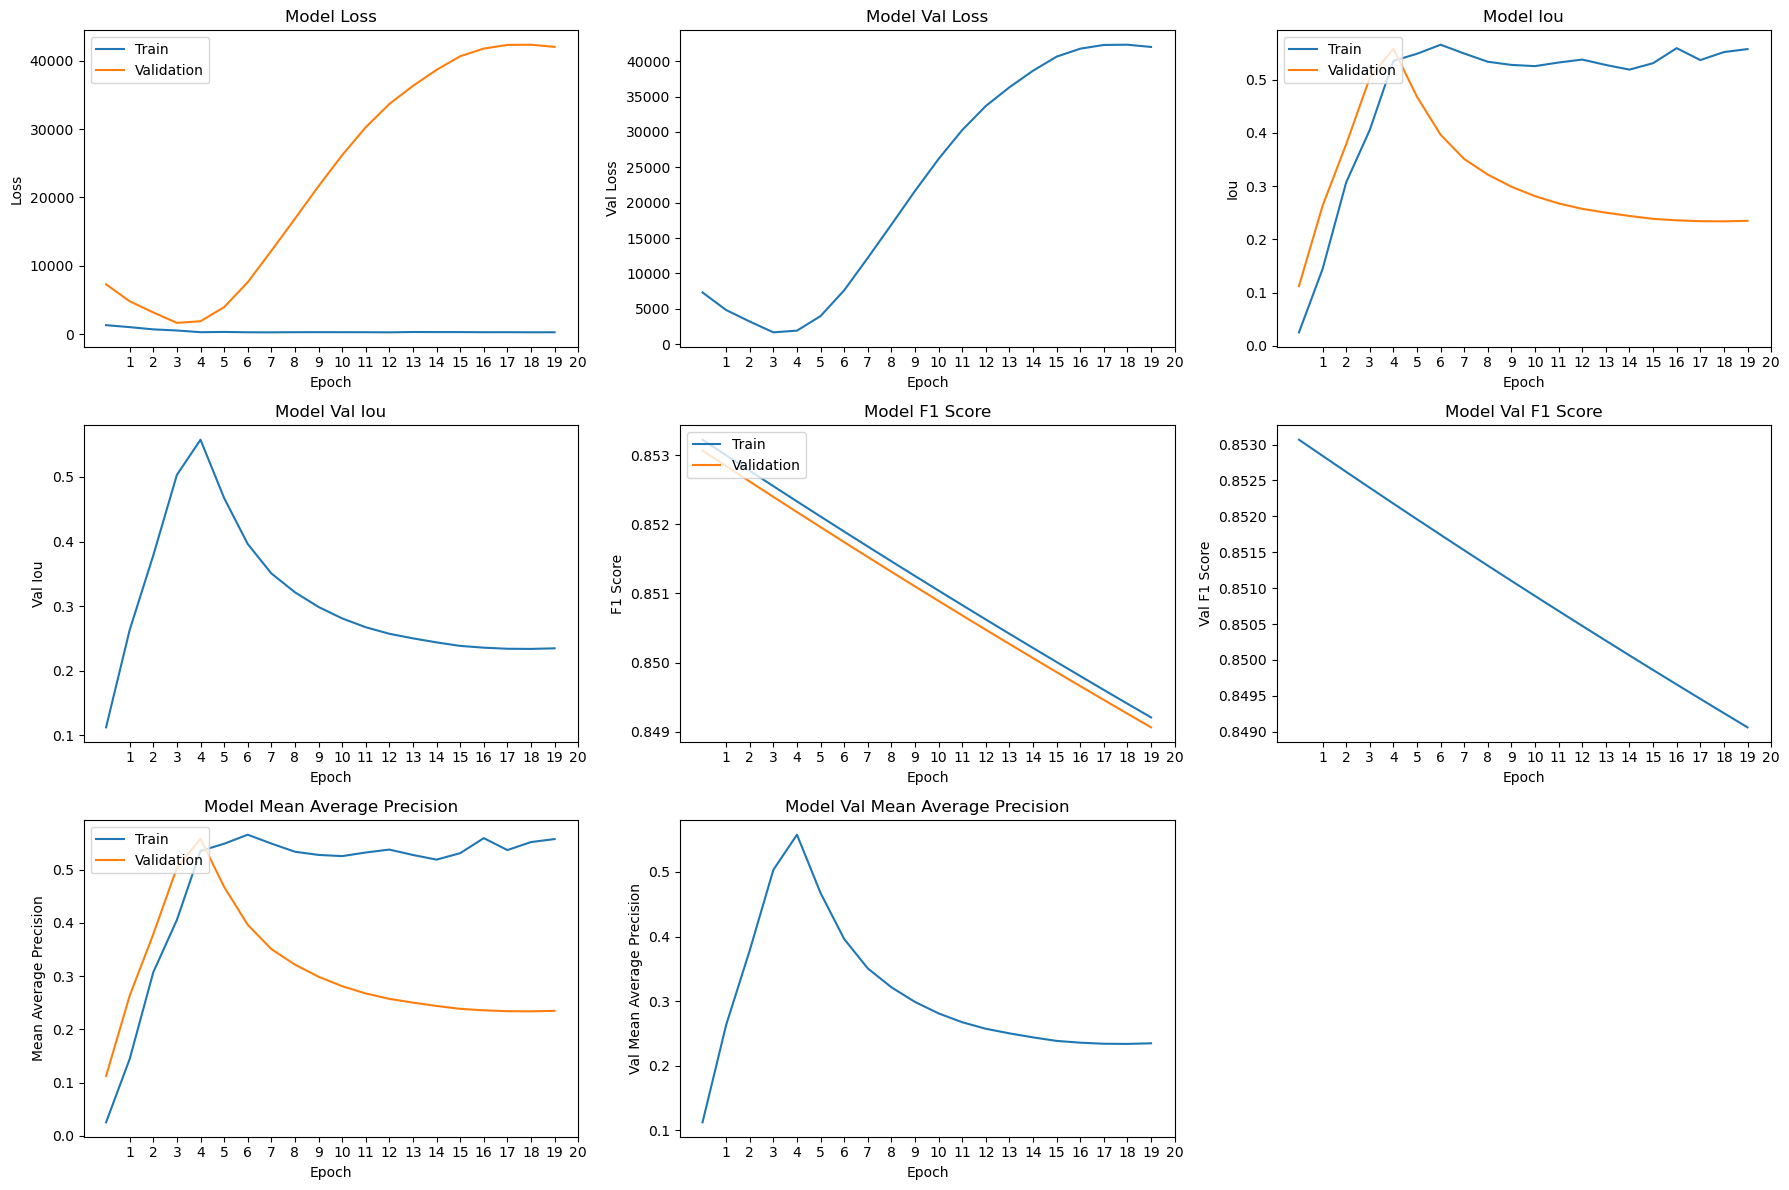

In [ ]:
plot_metrics(history_best2)

In [ ]:
best_model2.save(SAVE_PATH + 'best_custom_cnn_model3.keras')

In [ ]:
gc.collect()

# Testing

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


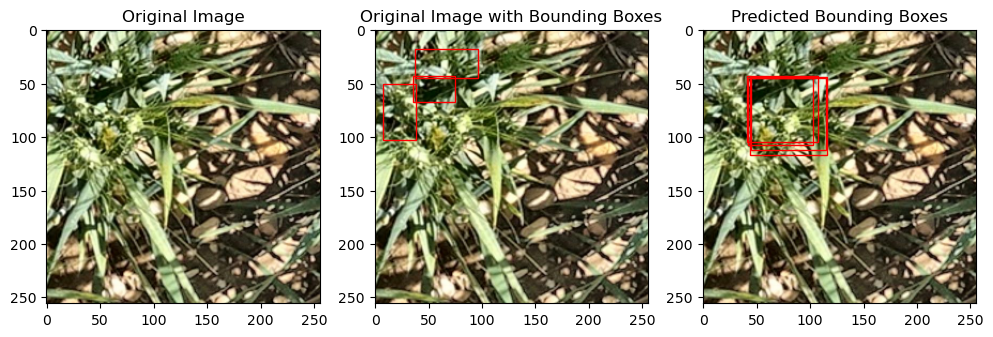

In [244]:
def filter_bboxes(bboxes, max_value=IMG_SIZE):
    all_bboxes = []
    for bbox in bboxes:
        x, y, w, h = bbox
        if x + w > max_value or y + h > max_value:
            pass
        else:
            all_bboxes.append(bbox)
    areas = calculate_bbox_area(bboxes)
    max_area_index = areas.index(max(areas))
    bbox_with_max_area = bboxes[max_area_index]
    xmin, ymin, width, height = bbox_with_max_area
    xmax, ymax = xmin + width, ymin + height
    all_all_bboxes = []
    for bbox in all_bboxes:
        x, y, w, h = bbox
        if x >= xmin and x <= xmax:
            pass
        elif y >= ymin and y + h <= ymax:
            pass
        elif x + w >= xmin and x + w <= xmax:
            pass
        elif y + h >= ymin and y + h <= ymax:
            pass
        else:
            all_all_bboxes.append(bbox)
    return all_all_bboxes
    
def calculate_bbox_area(bboxes):
    areas = []
    for bbox in bboxes:
        ymin, xmin, ymax, xmax = bbox
        width = xmax - xmin
        height = ymax - ymin
        area = width * height
        areas.append(area)
    return areas

# Function to plot image with bounding boxes
def plot_image_with_bboxes(ax, image, bboxes, t_bboxes=None, num_plot=None, reverse=True):
    # fig, ax = plt.subplots(1)
    ax.imshow(image)
    if num_plot is not None:
        if num_plot > len(bboxes):
            area_threshold = sorted(calculate_bbox_area(bboxes), reverse=reverse)
        else:
            area_threshold = sorted(calculate_bbox_area(bboxes), reverse=reverse)[num_plot-1]
    # scale = tf.cast(1024, tf.float32) / 256
    # bboxes = bboxes * scale
    for i in range(len(bboxes)):
        # bbox format: [ymin, xmin, ymax, xmax]
        ymin, xmin, ymax, xmax = bboxes[i]
        width, height = xmax - xmin, ymax - ymin
        rect = patches.Rectangle((xmin, ymin), width, height, linewidth=1, edgecolor='r', facecolor='none')
        if num_plot is not None:
            if reverse:
                if width * height > area_threshold:
                    ax.add_patch(rect)
            if not reverse:
                if width * height < area_threshold:
                    ax.add_patch(rect)
        else:
            ax.add_patch(rect)
        if t_bboxes is not None and np.all(t_bboxes[i] == 0):
            break

def predict_bboxes(model, image_array):
    model=model.model
    image_array = tf.expand_dims(image_array, axis=0)  # Add an extra dimension to the image array
    predictions = model.predict(image_array)
    bboxes = predictions[0]  # Remove batch dimension
    return bboxes

for x,y in test_dataset.take(1):
    image = x
    y = bboxes
    break

# Load the model
# model = tf.keras.models.load_model(SAVE_PATH + 'custom_cnn_model1.keras', custom_objects={'iou': IoU, 'PrecisionMetric': PrecisionMetric(), 'RecallMetric': RecallMetric(), 'F1ScoreMetric': F1ScoreMetric(), 'MeanAveragePrecision': MeanAveragePrecision()}, compile=True)
model = custom_cnn_model1

# Extract the image and bounding boxes
for x, y in test_dataset.take(1):
    image = x[10].numpy()
    bboxes = y[10].numpy()
    break

# Plot the original image
fig, axes = plt.subplots(1, 3, figsize=(12, 6))
axes[0].imshow(image)
axes[0].set_title('Original Image')

# Plot the image with bounding boxes
plot_image_with_bboxes(axes[1], image, bboxes)
# axes[1].imshow(image)
axes[1].set_title('Original Image with Bounding Boxes')

bboxes_pred = predict_bboxes(model, image)
plot_image_with_bboxes(axes[2], image, bboxes_pred, bboxes)
# axes[2].imshow(image)
axes[2].set_title('Predicted Bounding Boxes')

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


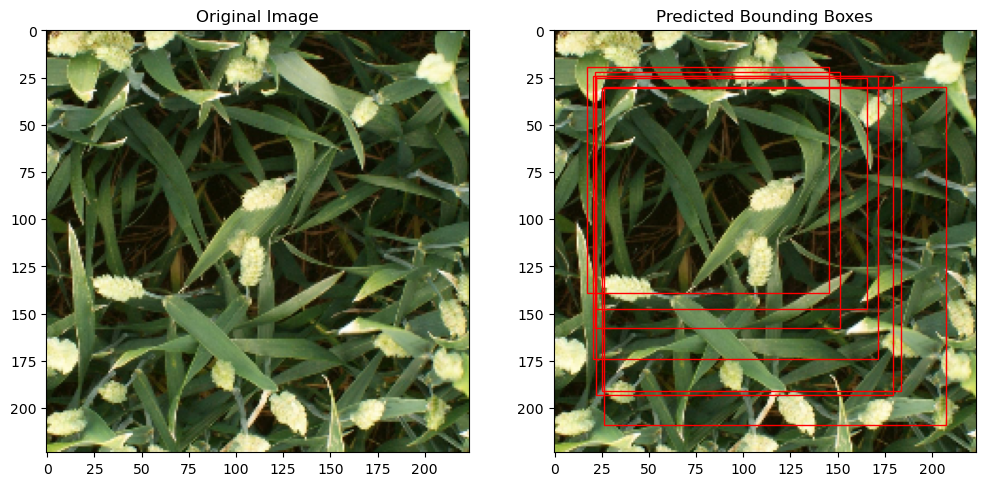

In [245]:
# Load and preprocess the image
def load_and_preprocess_image(image_path, IMG_SIZE=224):
    target_size = (IMG_SIZE, IMG_SIZE)
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    original_size = tf.shape(image)[:2]
    
    image = tf.image.resize(image, target_size)
    image_array = np.array(image)
    image_array = image_array / 255.0  # Normalize the image
    
    image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension
    scale = tf.cast(original_size[0], tf.float32) / IMG_SIZE
    
    # Convert the image tensor to a NumPy array for display
    image_for_display = image.numpy() / 255.0
    
    return image_array, image_for_display, scale

# Load the model
# model = tf.keras.models.load_model('path_to_your_model.h5')

# Example usage
image_path = './global-wheat-detection/test/2fd875eaa.jpg'
image_array, image, scale = load_and_preprocess_image(image_path)
bboxes = predict_bboxes(model, image)
bboxes = bboxes * scale
bboxes = filter_bboxes(bboxes, max_value=256)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(image)
axes[0].set_title('Original Image')

# Plot the bounding boxes
plot_image_with_bboxes(axes[1], image, bboxes, num_plot=8)
axes[1].set_title('Predicted Bounding Boxes')
plt.show()

# OS

In [ ]:
import os

# Path to your MP3 file
# mp3_file = r"C:\Users\WenShen\Documents\GitHub\That's Why I Like You.mp3"

# Use the os module to call Windows Media Player
# os.system(f'start wmplayer "{mp3_file}"')

sh: start: command not found


32512

- hyperparameter tuning and models path zip and send to me for compile